In [ ]:
©Liu Xiaoquan,assistant Professor, HKCHC

Data range: 20210523 ~ 20250923
Constituents: 89
[Cache] Loading raw_prices.csv
Return matrix shape: (1054, 89)
[Info] LedoitWolf failed fallback sample: Input X contains NaN.
LedoitWolf does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


/var/folders/cl/wbfw5l6x06qggs_8v4x0__th0000gn/T/ipykernel_76636/2756639112.py:231: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ret = pivot.pct_change()


[Info] LedoitWolf failed fallback sample: Input X contains NaN.
LedoitWolf does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
[Info] LedoitWolf failed fallback sample: Input X contains NaN.
LedoitWolf does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possi

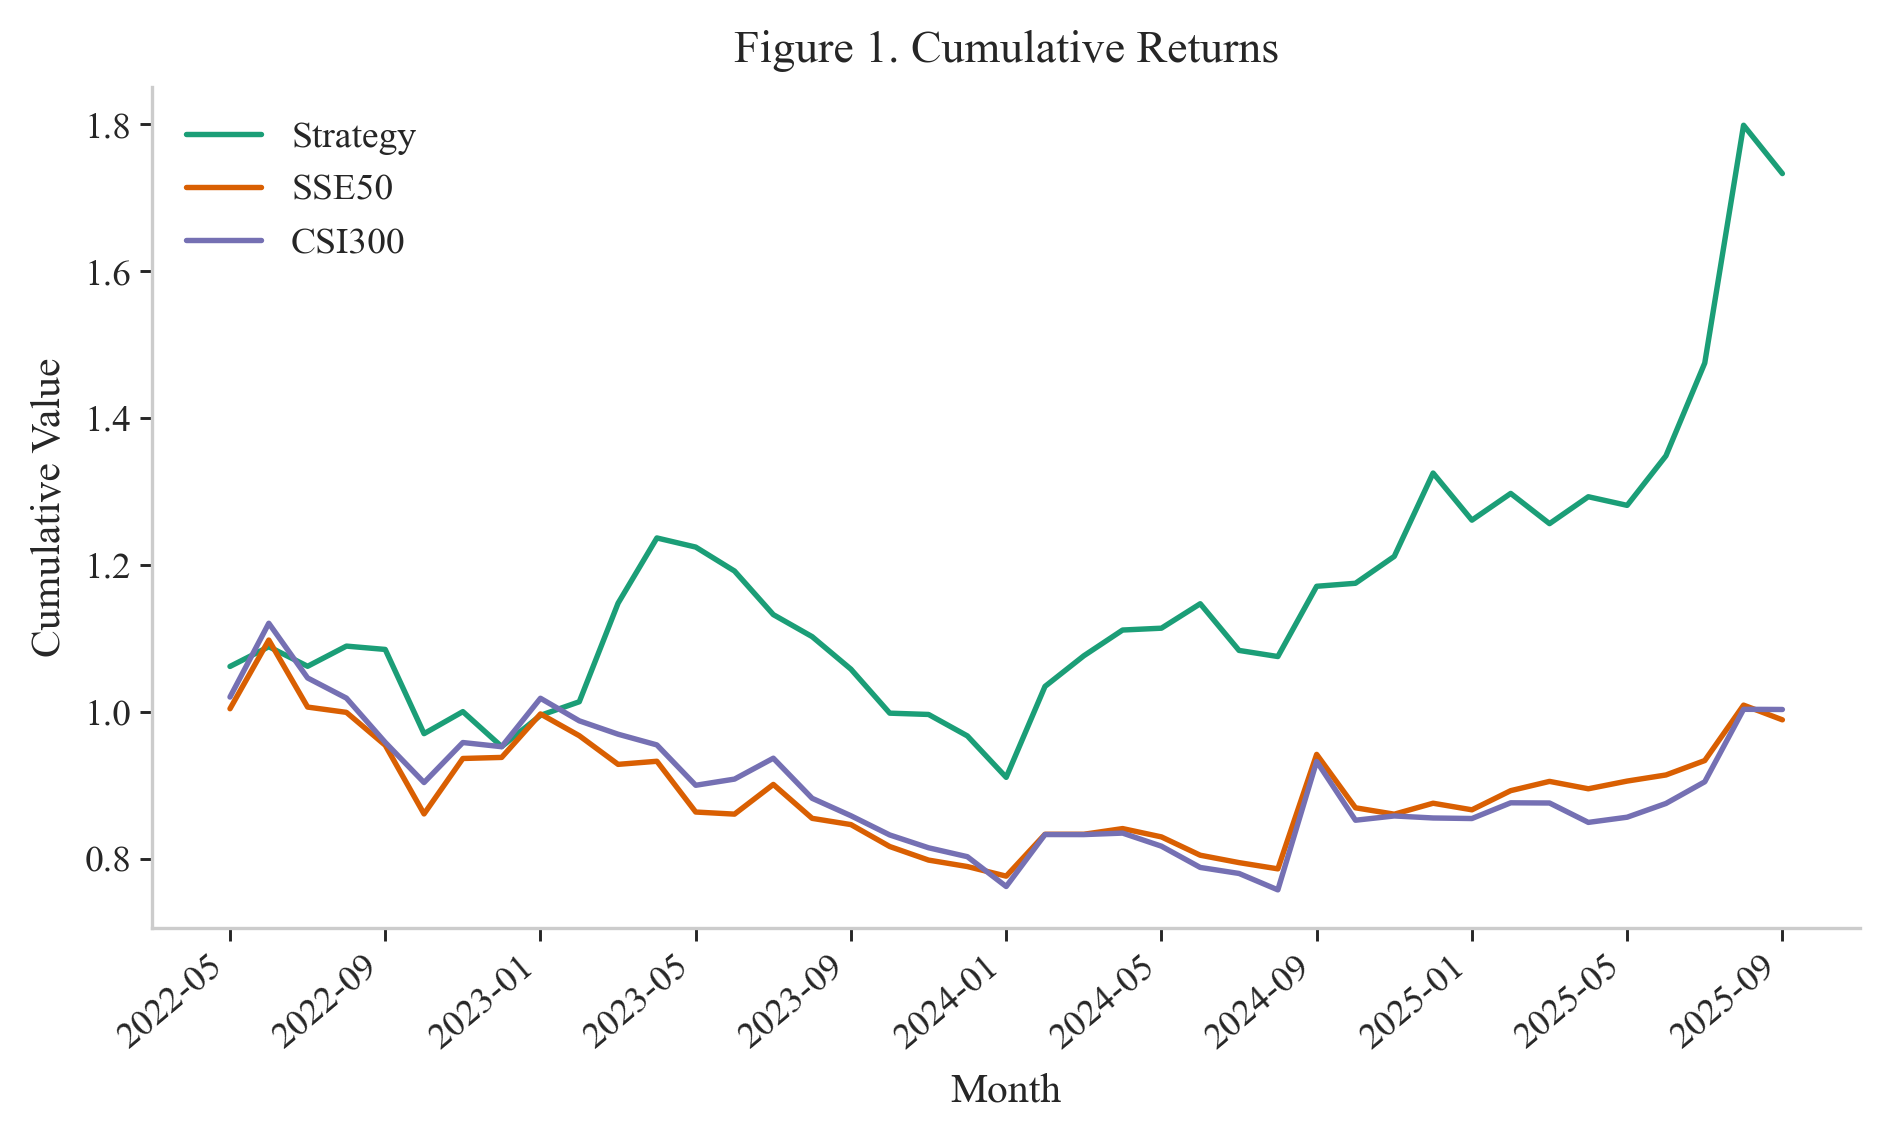

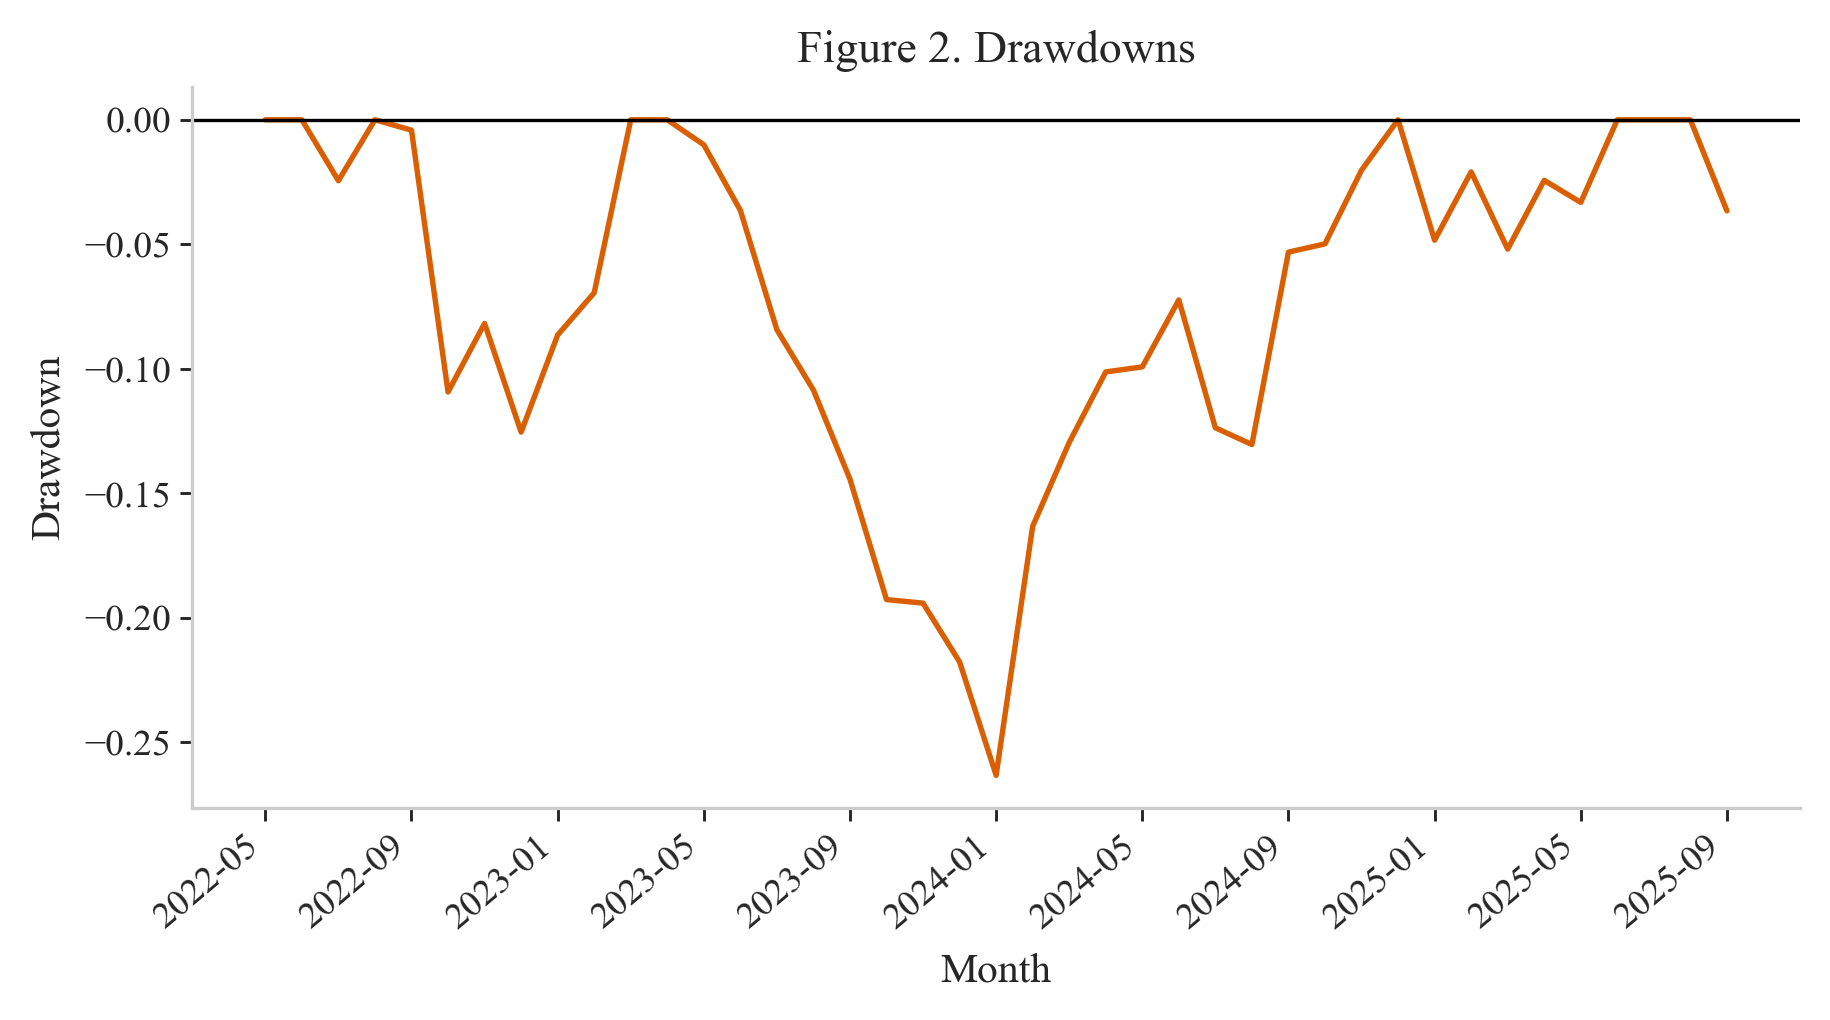

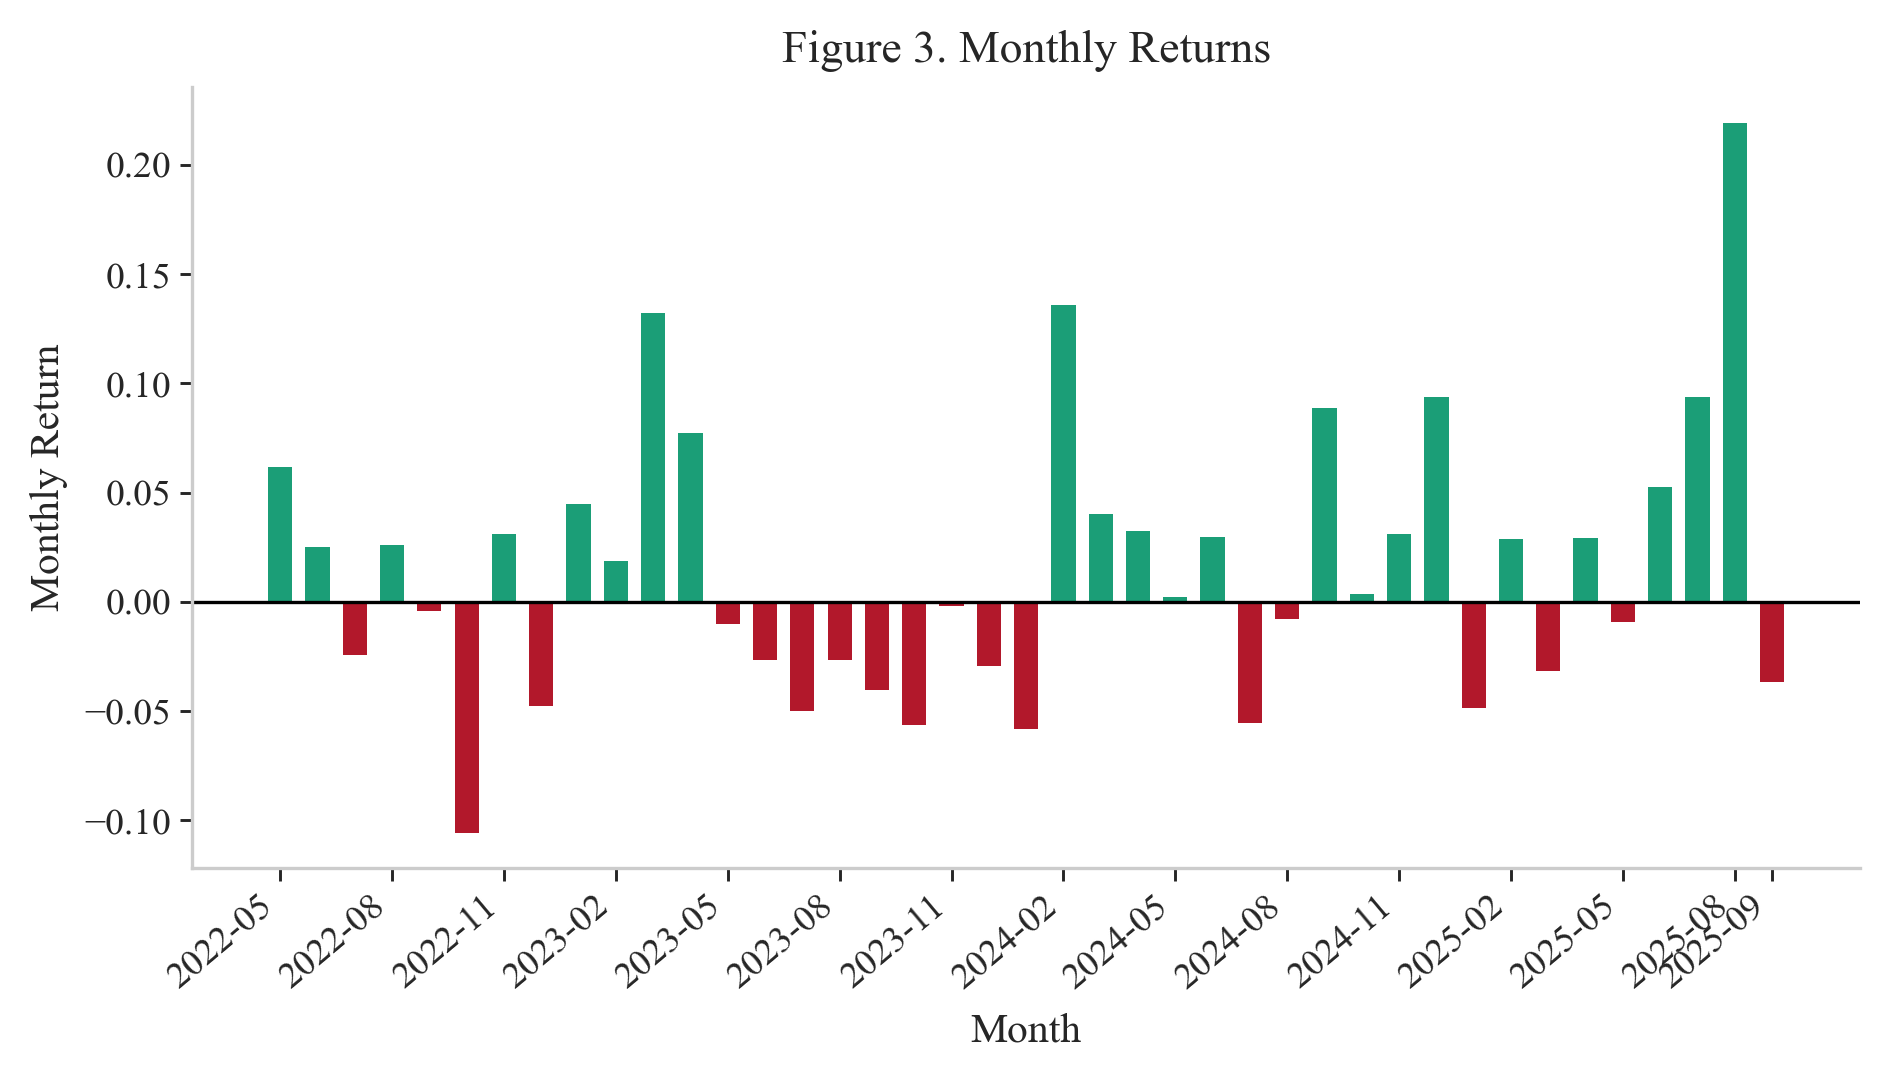

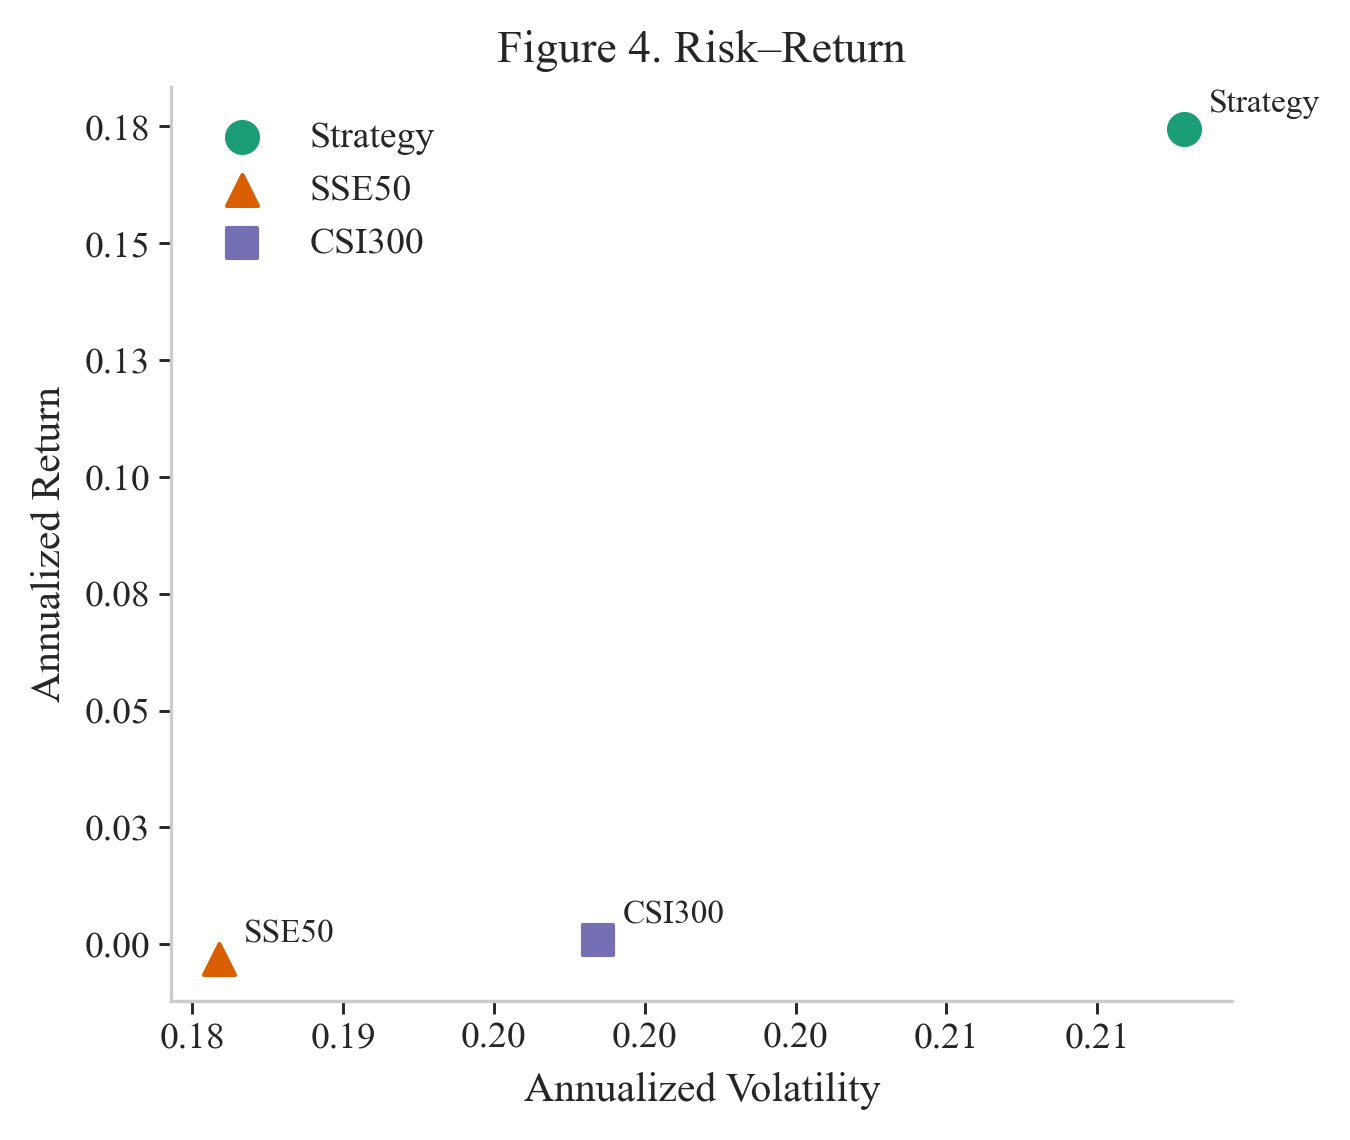

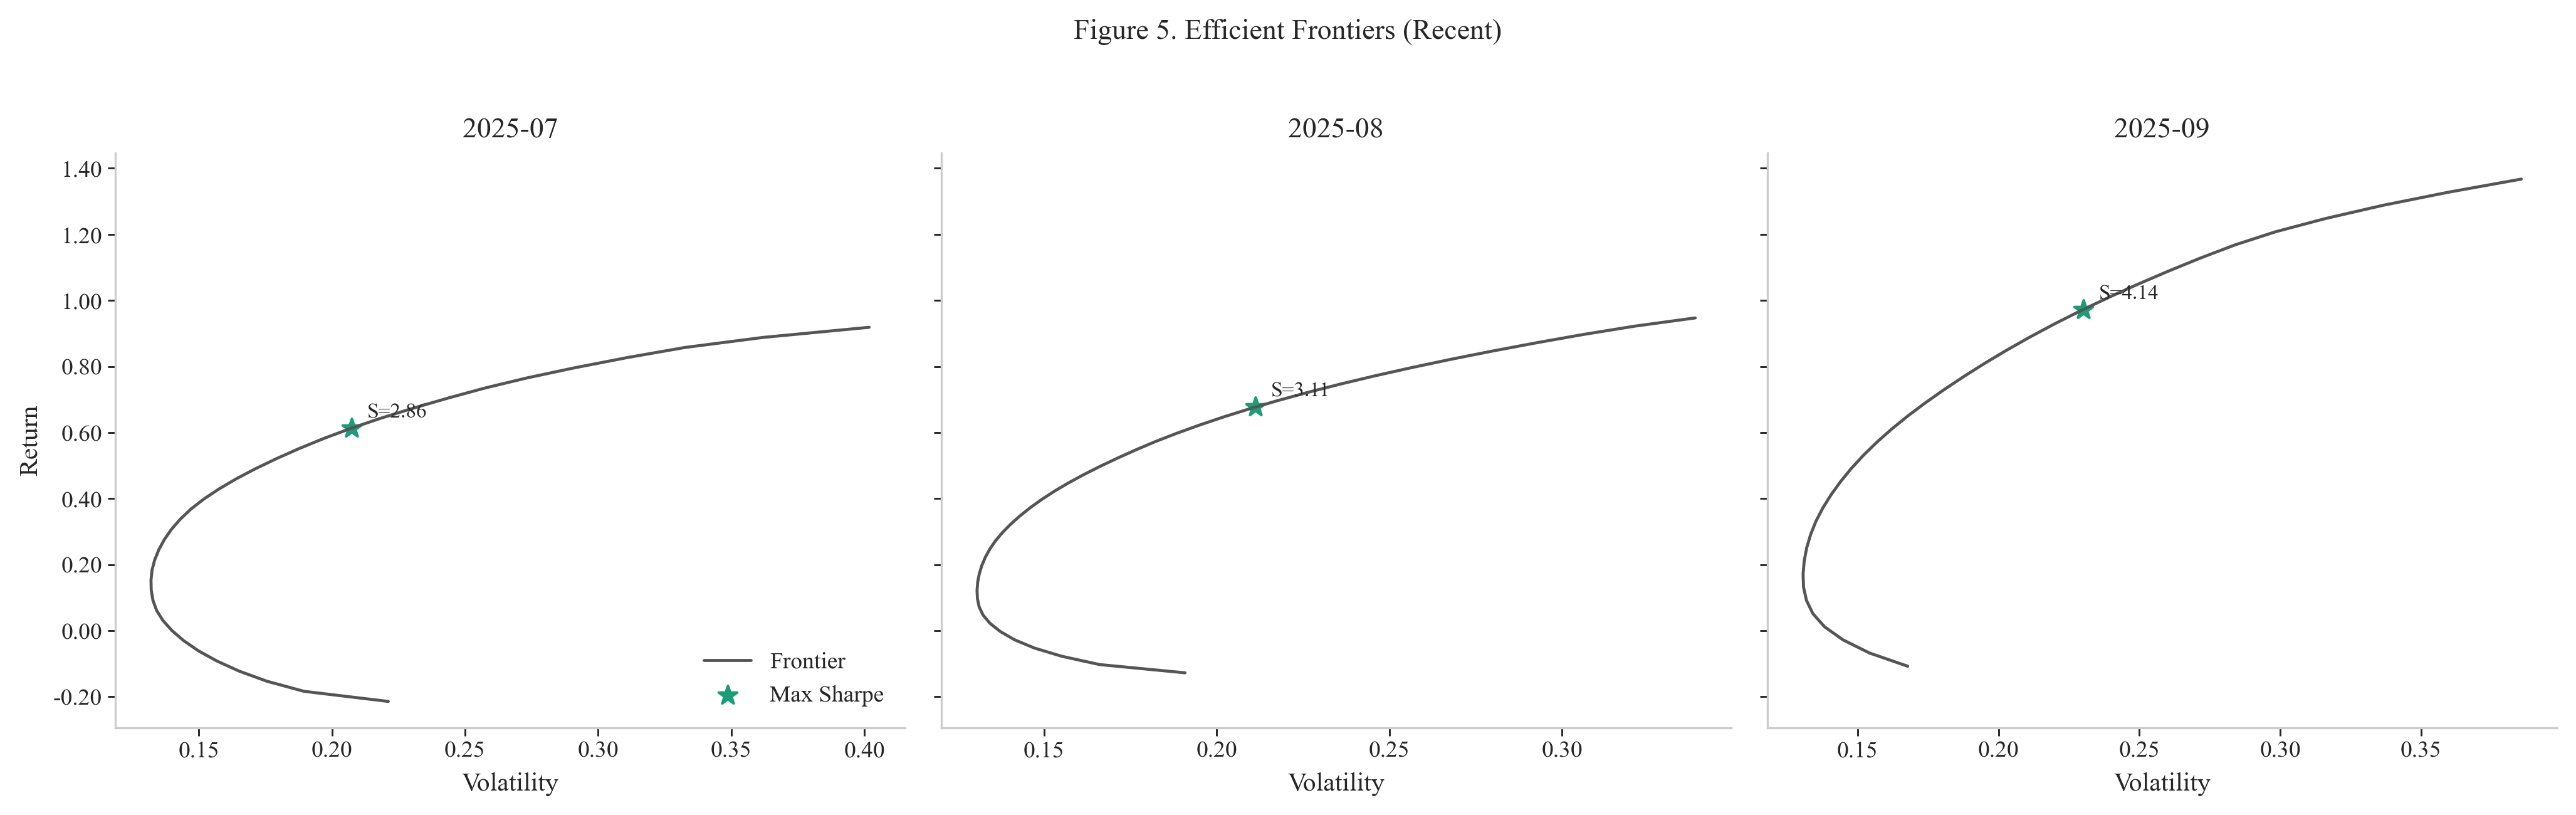

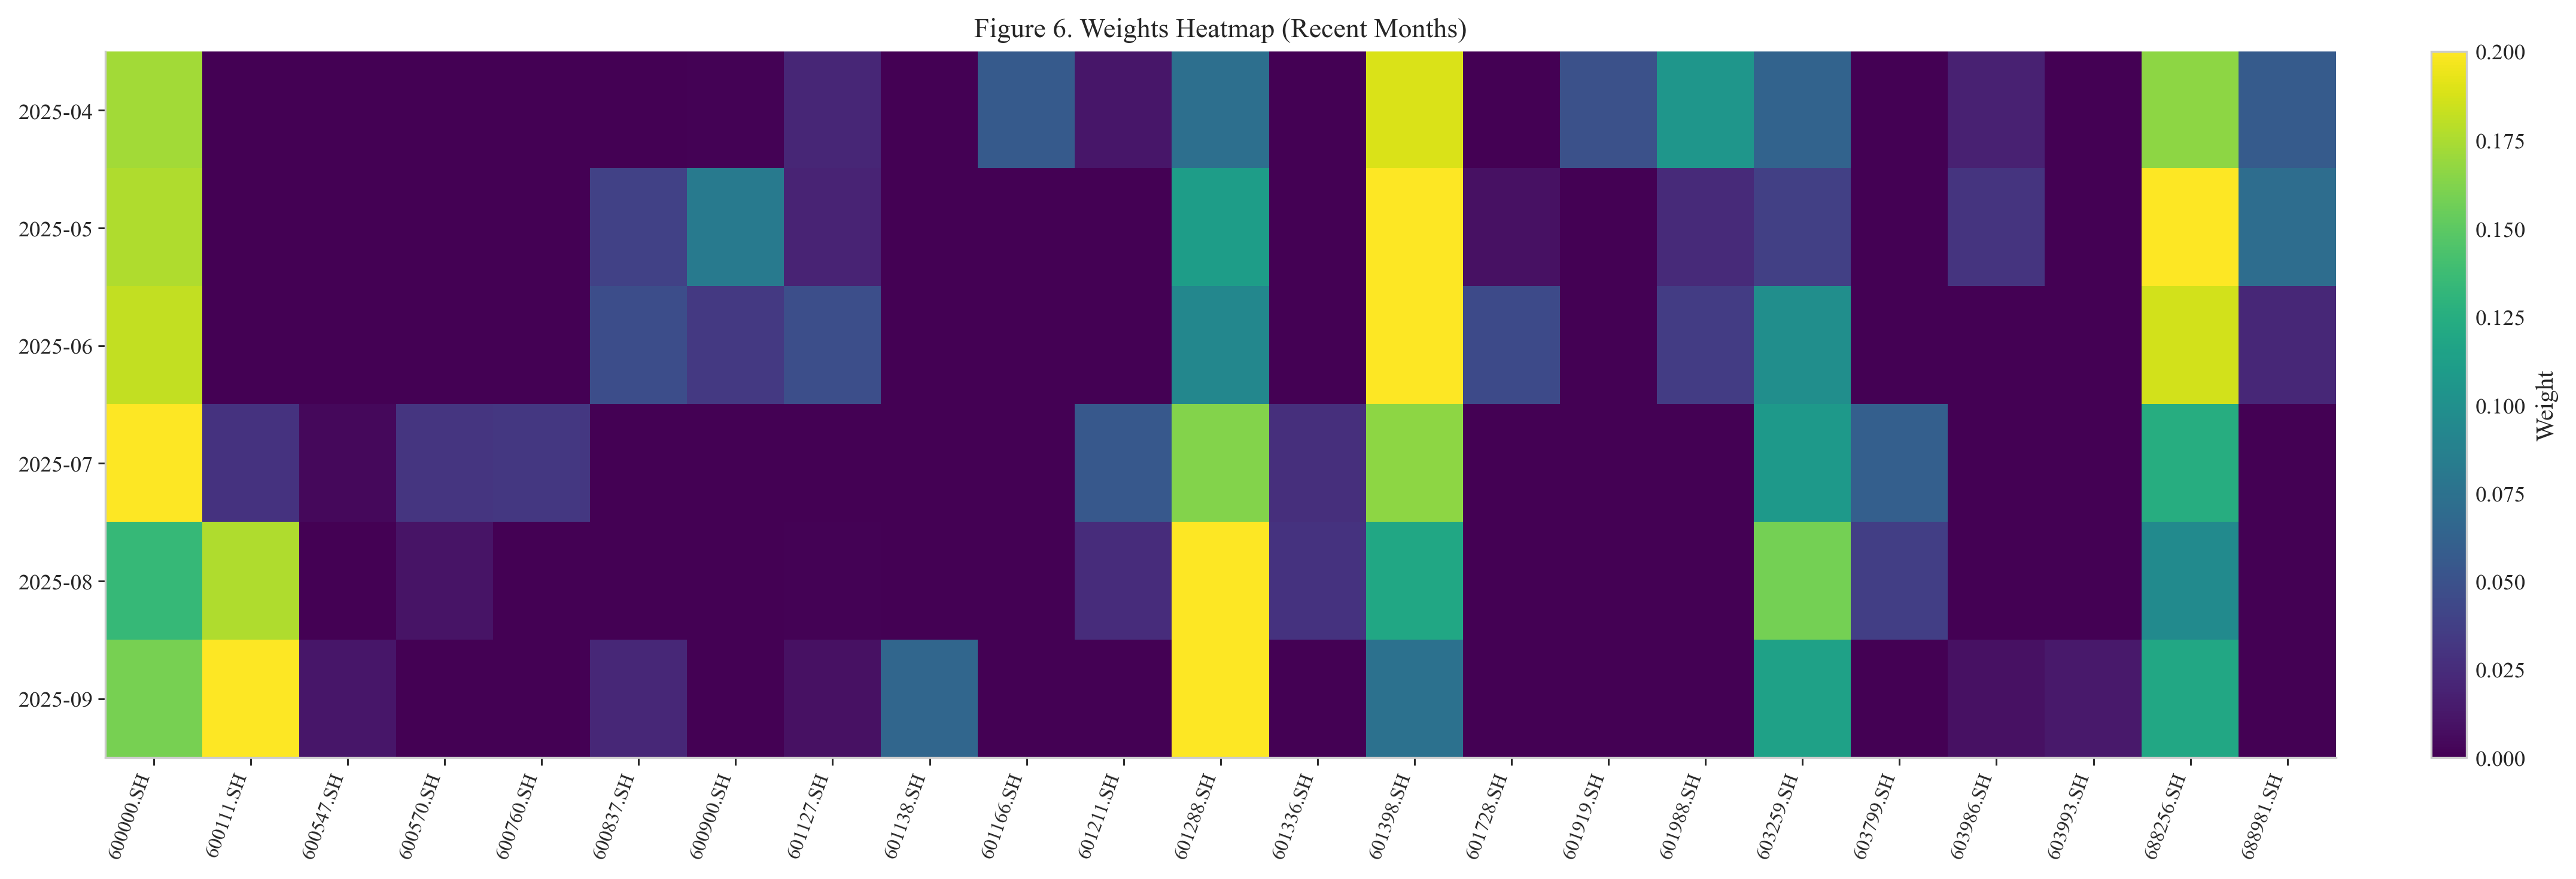

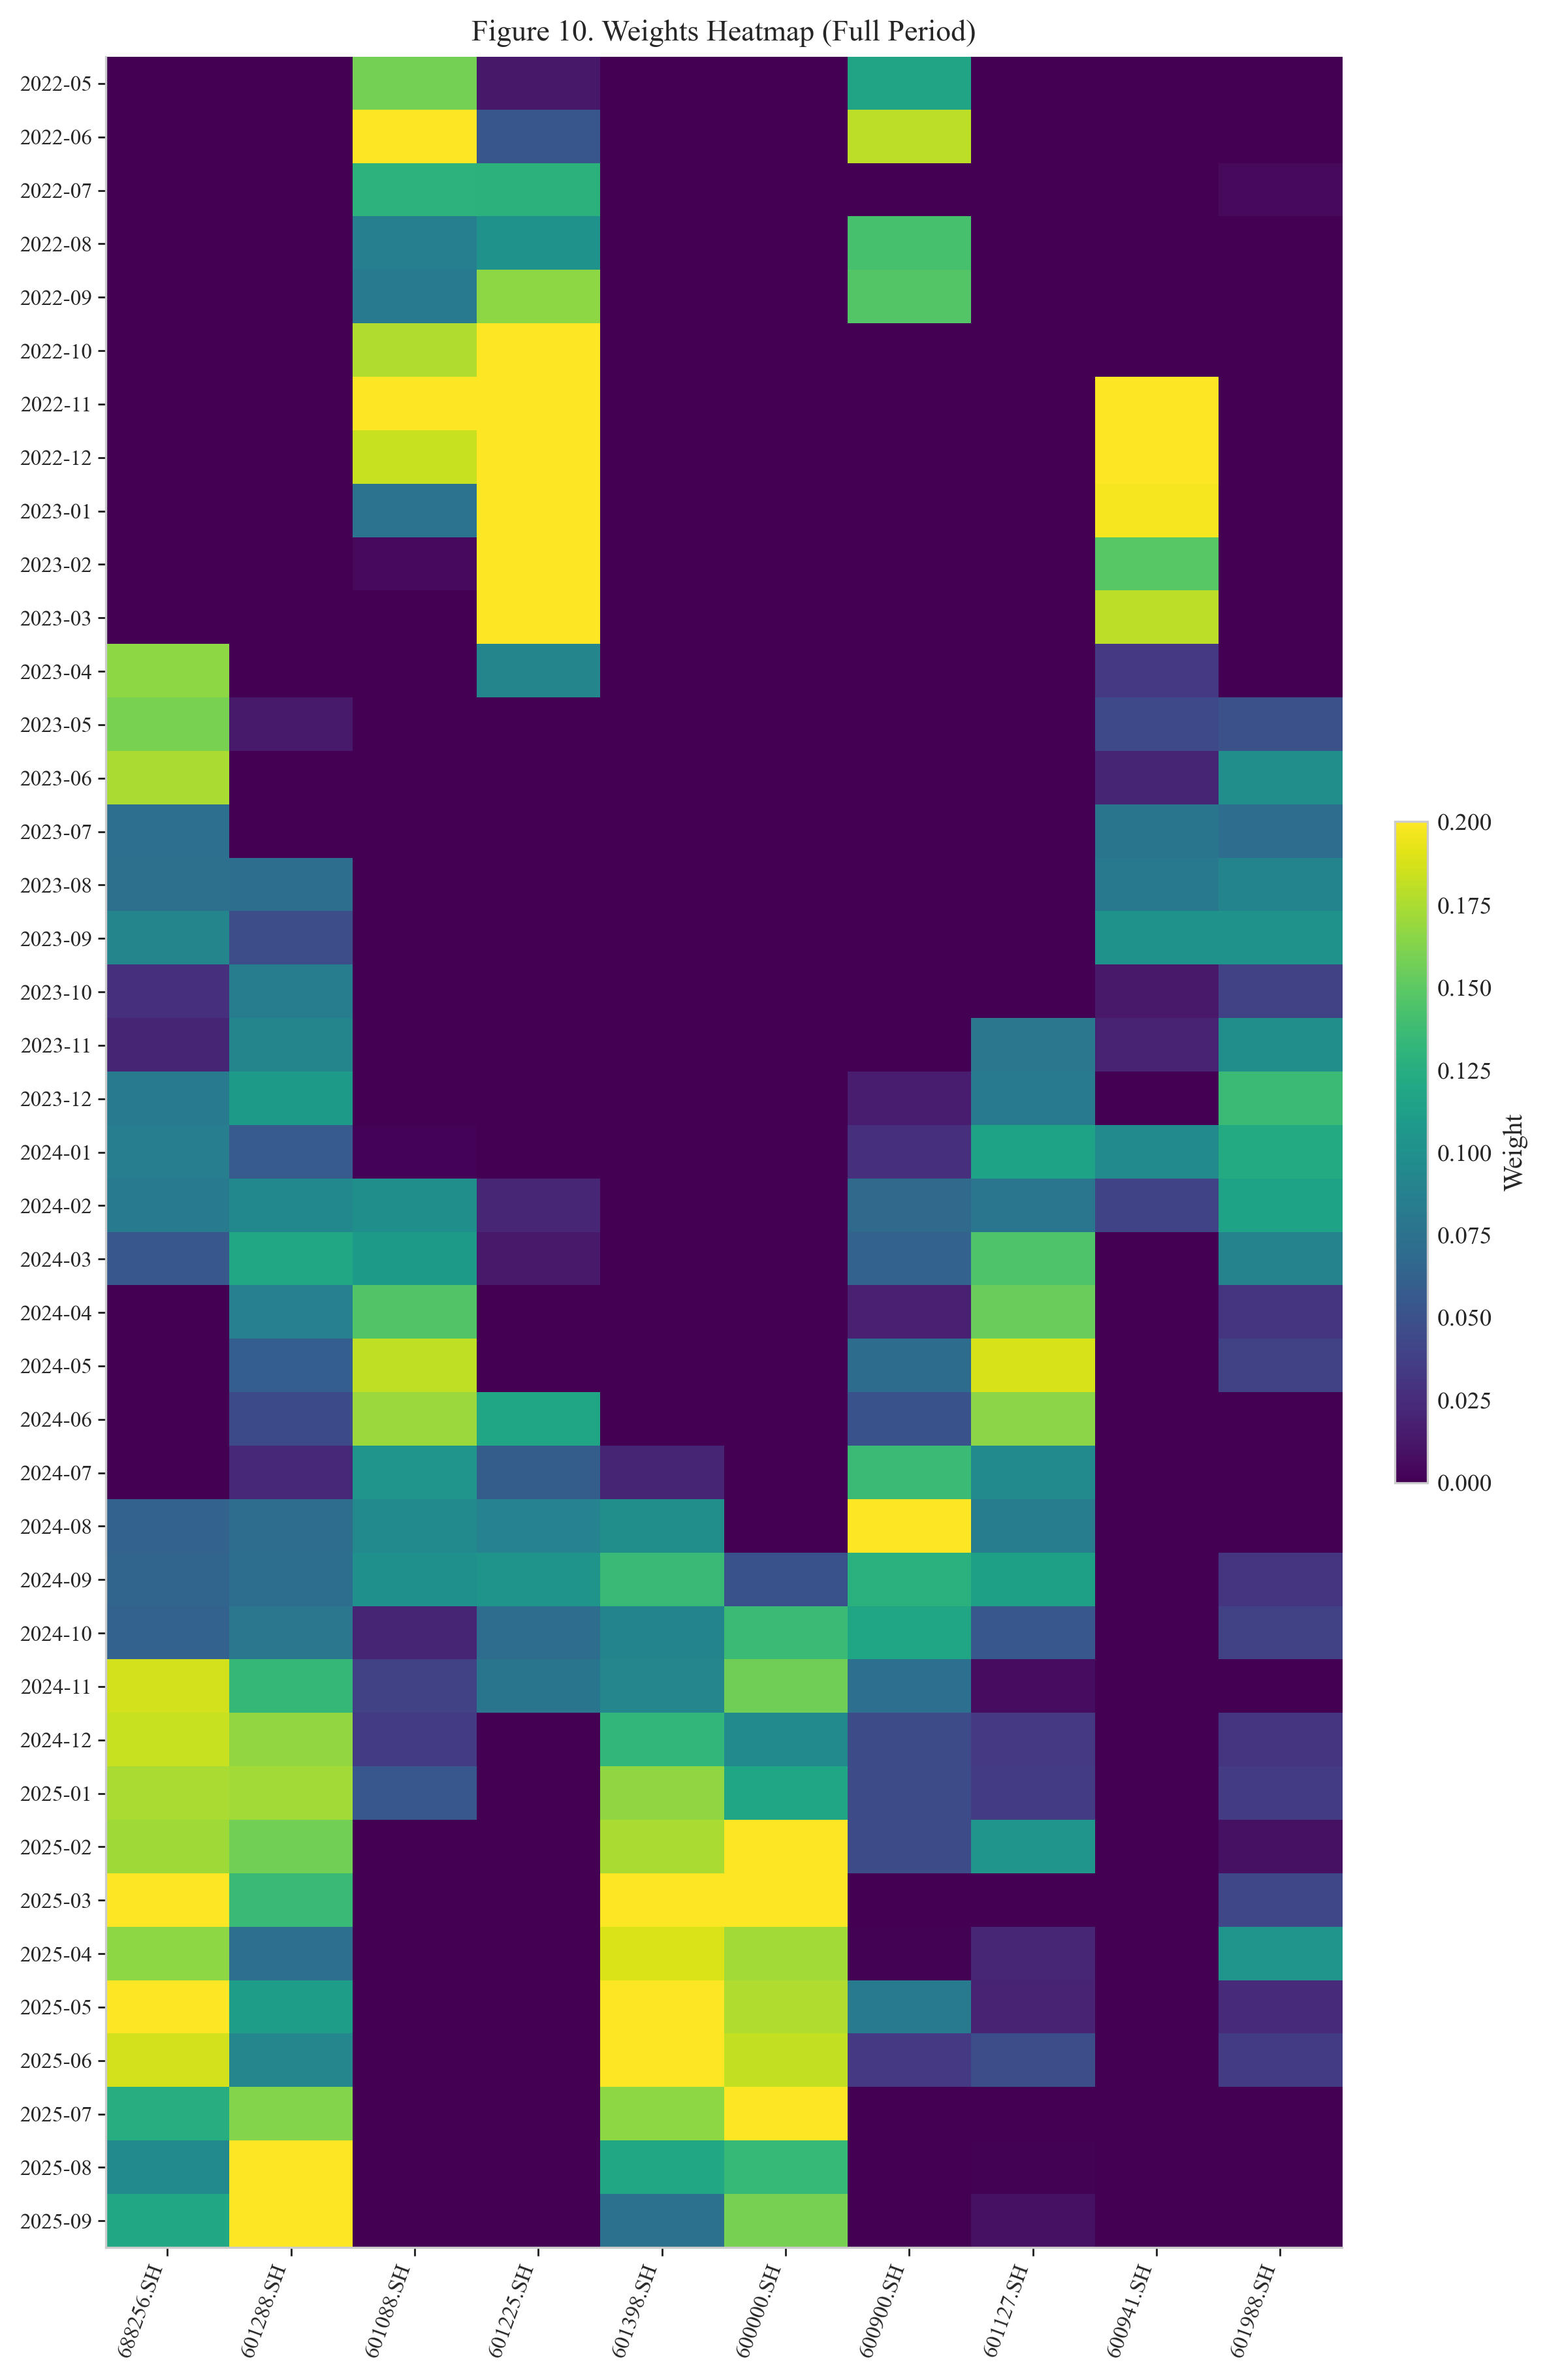

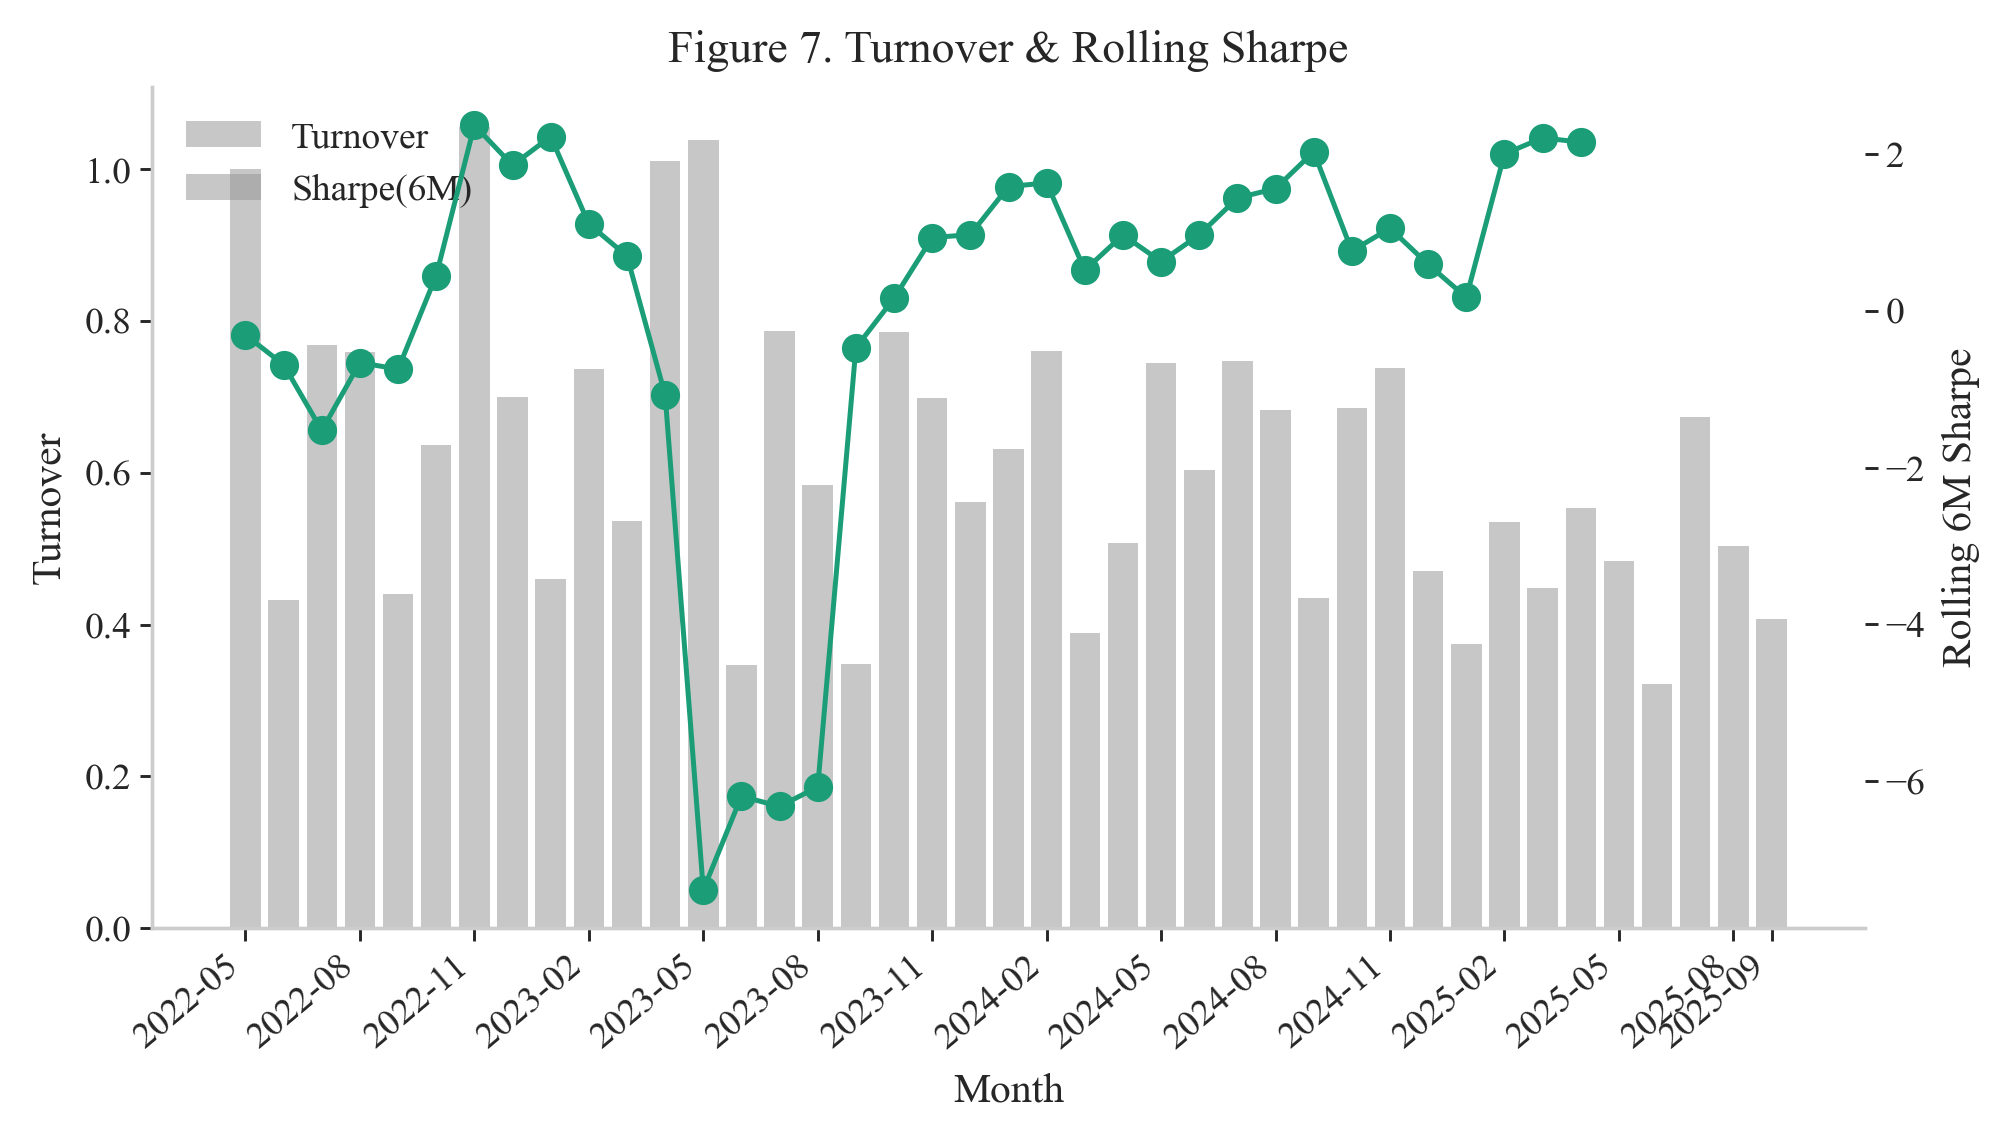

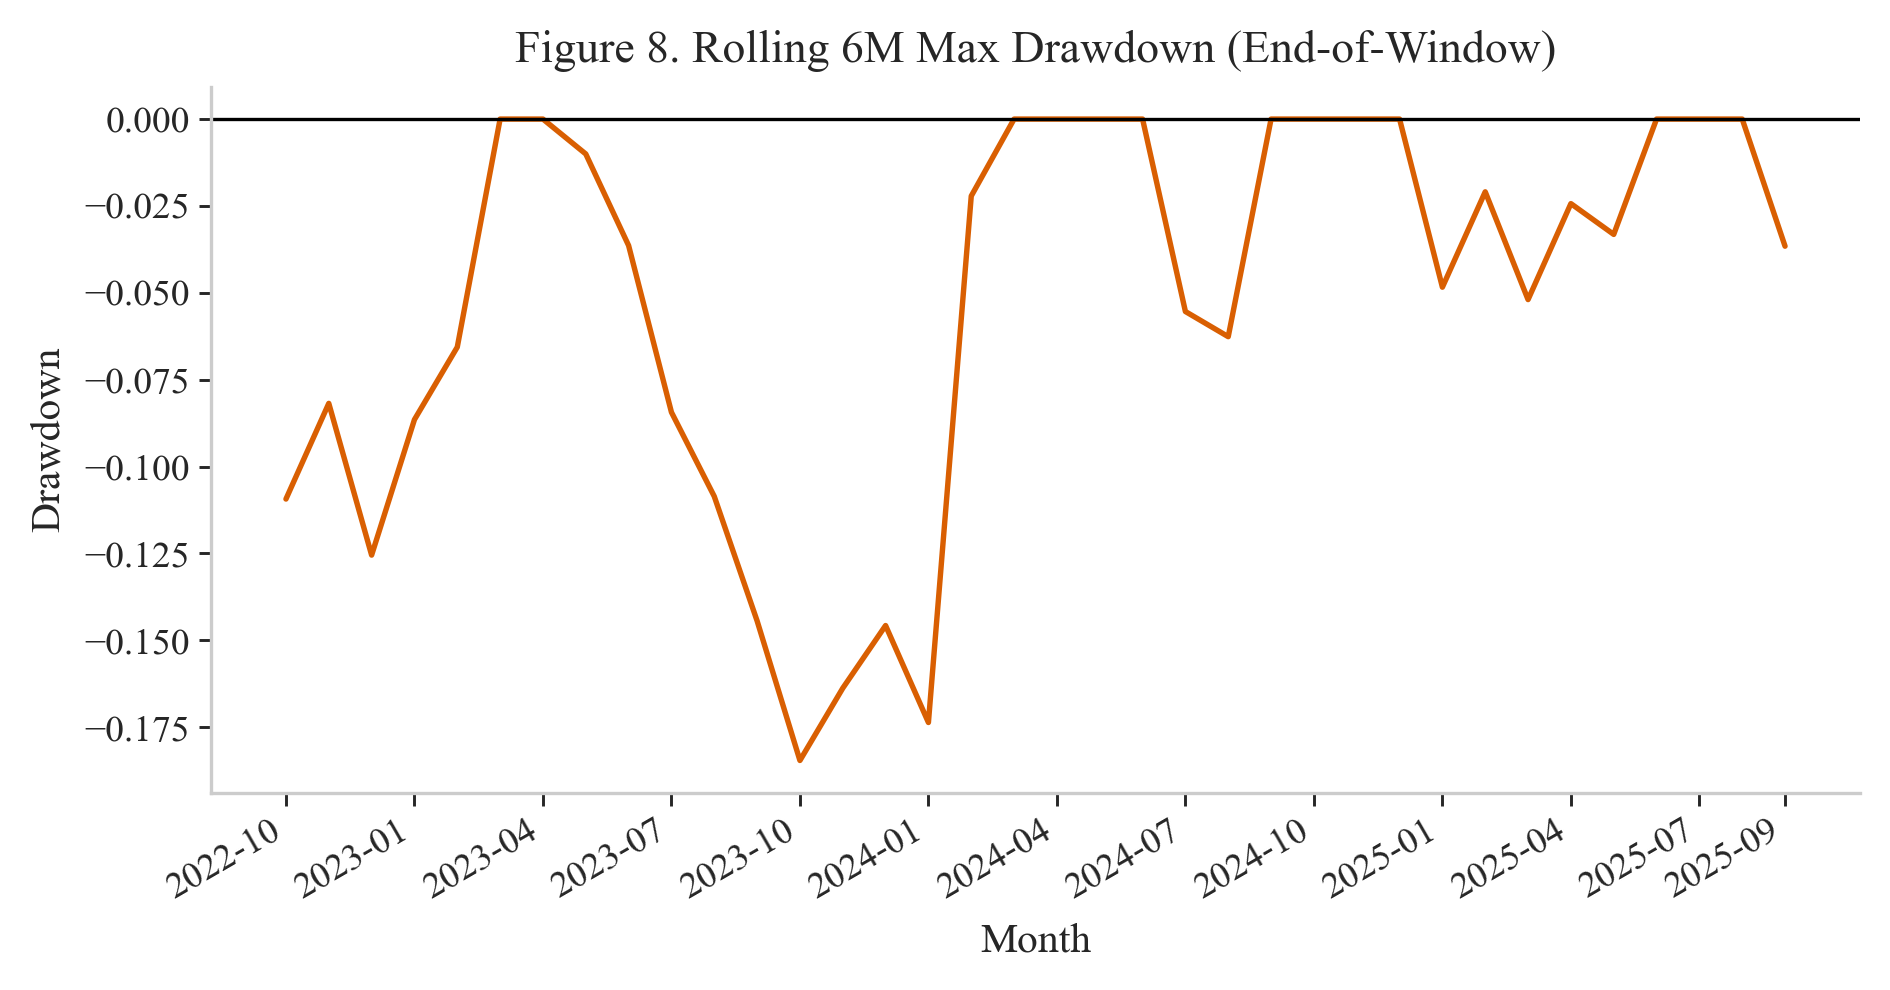

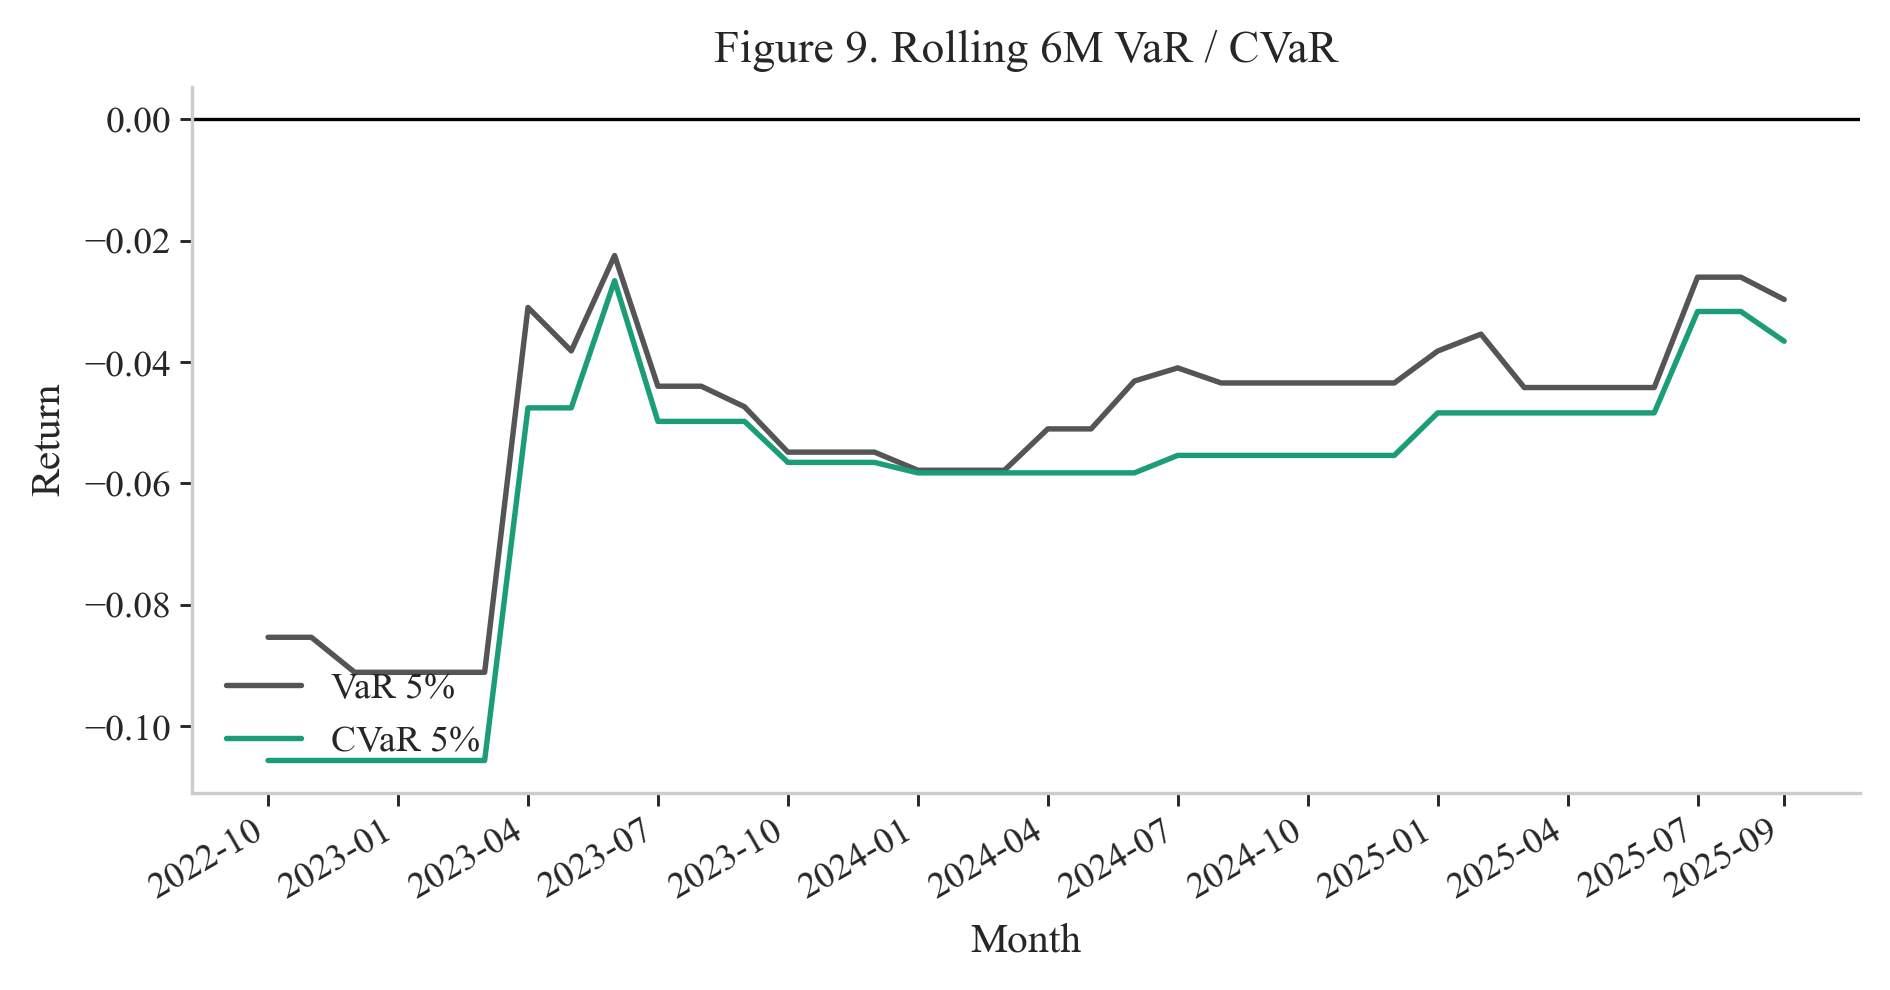


Recent Months Top Weights:

2025-07:
ts_code
600000.SH    0.200000
601398.SH    0.165795
601288.SH    0.162984
688256.SH    0.124879
603259.SH    0.107517
603799.SH    0.060659
601211.SH    0.054777
600760.SH    0.032536
600570.SH    0.030541
600111.SH    0.029208
dtype: float64

2025-08:
ts_code
601288.SH    0.200000
600111.SH    0.176306
603259.SH    0.158213
600000.SH    0.133829
601398.SH    0.119380
688256.SH    0.095968
603799.SH    0.037297
601336.SH    0.029626
601211.SH    0.025263
600570.SH    0.010186
dtype: float64

2025-09:
ts_code
600111.SH    0.200000
601288.SH    0.200000
600000.SH    0.158714
688256.SH    0.119827
603259.SH    0.114652
601398.SH    0.074781
601138.SH    0.065877
600837.SH    0.022006
603993.SH    0.013437
600547.SH    0.012104
dtype: float64

[Exported] Results -> rolling_results.xlsx


In [5]:

import os
import warnings
import datetime as dt
from dateutil.relativedelta import relativedelta
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ===================== Global Config =====================
TUSHARE_TOKEN = os.environ.get("TUSHARE_TOKEN", "cb8d6c9ce12cf06aa54603af6a26ab4c660d1cfb2e20b0609872e051")
INDEX_CODE_SSE50 = "000016.SH"
INDEX_CODE_HS300  = "000300.SH"

LOOKBACK_MONTHS        = 12     # 滚动窗口（月）
TOTAL_MONTHS           = 36     # 目标投资期（月，不含回溯）
BUFFER_MONTHS          = 4
RISK_FREE_ANNUAL       = 0.02
ALLOW_SHORT            = False
MAX_WEIGHT             = 0.20
MIN_STOCKS_THRESHOLD   = 12
MIN_VALID_RATIO        = 0.80
COV_REG_LAMBDA         = 1e-4
USE_LEDOIT_WOLF        = True
RET_METHOD             = "simple"
RET_FILL               = True
RET_FILL_LIMIT         = 5
ANNUALIZE_DAILY        = 252
ANNUALIZE_MONTHLY      = 12
FRONTIER_LAST_N        = 3
FRONTIER_POINTS        = 60
TOP_SHOW               = 10
EXPORT_RESULTS         = True
RESULT_FILE            = "rolling_results.xlsx"
SAVE_FIGURES           = True
FIG_DIR                = "figures"
FIG_FORMATS            = ["pdf", "png"]
FIG_DPI                = 300
VERBOSE                = True
FORCE_DOWNLOAD         = False
CACHE_DIR              = "cache"
TRANSACTION_COST_PER_TURNOVER = 0.001   # 每单位权重变化成本 (例如 10bps)
APPLY_TRANSACTION_COST = True
VAR_CVAR_CONF          = 0.05
ROLLING_WINDOW_METRICS = 6
MAX_CONCENTRATION_HHI  = 0.18

# 静态回退成份
STATIC_CONSTITUENTS = [
    '600000.SH','600016.SH','600019.SH','600028.SH','600030.SH','600031.SH',
    '600036.SH','600048.SH','600050.SH','600089.SH','600104.SH','600111.SH',
    '600256.SH','600276.SH','600309.SH','600519.SH','600547.SH','600585.SH',
    '600588.SH','600606.SH','600690.SH','600745.SH','600809.SH','600837.SH',
    '600845.SH','600887.SH','600893.SH','600900.SH','600905.SH','600919.SH',
    '600938.SH','600958.SH','600999.SH','601012.SH','601066.SH','601088.SH',
    '601166.SH','601169.SH','601186.SH','601211.SH','601288.SH','601318.SH',
    '601319.SH','601328.SH','601336.SH','601390.SH','601398.SH','601601.SH',
    '601628.SH','601668.SH'
]

# =============== Style ===============
def set_journal_style():
    mpl.rcParams.update({
        "figure.dpi": FIG_DPI,
        "savefig.dpi": FIG_DPI,
        "font.family": "Times New Roman",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.linewidth": 0.8,
        "lines.linewidth": 1.3,
        "grid.alpha": 0.15,
        "axes.grid": False,
        "pdf.fonttype": 42,
        "ps.fonttype": 42
    })
    available_fonts = {f.name for f in mpl.font_manager.fontManager.ttflist}
    if "Times New Roman" not in available_fonts:
        mpl.rcParams["font.family"] = "DejaVu Serif"

def format_axes(ax):
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)
    ax.tick_params(axis='both', direction='out', width=0.7, length=3, pad=2)

def apply_month_xticks(ax, labels, max_ticks=12):
    labels = list(labels)
    n = len(labels)
    if n == 0: return
    step = max(1, int(np.ceil(n / max_ticks)))
    positions = list(range(0, n, step))
    if positions[-1] != n - 1:
        positions.append(n - 1)
    ax.set_xticks(positions)
    ax.set_xticklabels([labels[i] for i in positions],
                       rotation=30 if n <= 36 else 40, ha='right')

def log(msg):
    if VERBOSE:
        print(msg)

# =============== Utility ===============
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def save_figure(fig, name):
    if not SAVE_FIGURES: return
    ensure_dir(FIG_DIR)
    for fmt in FIG_FORMATS:
        fig.savefig(os.path.join(FIG_DIR, f"{name}.{fmt}"),
                    format=fmt, bbox_inches='tight')

def monthly_labels(index_like):
    return pd.to_datetime(index_like).to_series().dt.to_period("M").astype(str).values

def compute_start_end_dates(total_months, lookback_months, buffer_months):
    today = dt.datetime.today()
    start_buffer = total_months + lookback_months + buffer_months
    start_dt = today - relativedelta(months=start_buffer)
    return start_dt.strftime("%Y%m%d"), today.strftime("%Y%m%d")

# =============== Data Layer ===============
ts.set_token(TUSHARE_TOKEN)
pro = ts.pro_api()

def cached_path(name):
    ensure_dir(CACHE_DIR)
    return os.path.join(CACHE_DIR, name)

def fetch_index_weights(index_code, start_date, end_date):
    try:
        df = pro.index_weight(index_code=index_code, start_date=start_date, end_date=end_date)
        if df is None or df.empty:
            log(f"[Warn] index_weight empty {index_code}")
            return pd.DataFrame(columns=['trade_date','trade_month','ts_code','weight'])
        if 'con_code' in df.columns and 'ts_code' not in df.columns:
            df.rename(columns={'con_code':'ts_code'}, inplace=True)
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df['trade_month'] = df['trade_date'].dt.to_period('M').astype(str)
        return df[['trade_date','trade_month','ts_code','weight']].sort_values('trade_date')
    except Exception as e:
        log(f"[Exception] index_weight: {e}")
        return pd.DataFrame(columns=['trade_date','trade_month','ts_code','weight'])

def fetch_daily_prices(ts_codes, start_date, end_date):
    all_data=[]
    for code in ts_codes:
        try:
            df = pro.daily(ts_code=code, start_date=start_date, end_date=end_date)
            if df is None or df.empty: continue
            df['trade_date'] = pd.to_datetime(df['trade_date'])
            df.sort_values('trade_date', inplace=True)
            all_data.append(df[['trade_date','ts_code','close']])
        except Exception as e:
            log(f"[Warn] fetch {code} failed: {e}")
    if not all_data:
        return pd.DataFrame(columns=['trade_date','ts_code','close'])
    return pd.concat(all_data, ignore_index=True)

def fetch_index_daily(index_code, start_date, end_date):
    try:
        df = pro.index_daily(ts_code=index_code, start_date=start_date, end_date=end_date)
        if df is None or df.empty:
            return pd.DataFrame(columns=['trade_date','close'])
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.sort_values('trade_date', inplace=True)
        return df[['trade_date','close']]
    except Exception as e:
        log(f"[Warn] index {index_code} daily fail: {e}")
        return pd.DataFrame(columns=['trade_date','close'])

def load_or_download_data(start_date, end_date, constituents):
    price_cache = cached_path("raw_prices.csv")
    if (not FORCE_DOWNLOAD) and os.path.exists(price_cache):
        log("[Cache] Loading raw_prices.csv")
        price_df = pd.read_csv(price_cache, parse_dates=['trade_date'])
    else:
        price_df = fetch_daily_prices(constituents, start_date, end_date)
        price_df.to_csv(price_cache, index=False)
    return price_df

def load_or_download_index(start_date, end_date, code, fname):
    path = cached_path(fname)
    if (not FORCE_DOWNLOAD) and os.path.exists(path):
        return pd.read_csv(path, parse_dates=['trade_date'])
    df = fetch_index_daily(code, start_date, end_date)
    df.to_csv(path, index=False)
    return df

# =============== Return & Covariance ===============
def compute_returns(price_df, method='simple', fill=True, fill_limit=None):
    if price_df.empty:
        return pd.DataFrame()
    pivot = price_df.pivot(index='trade_date', columns='ts_code', values='close').sort_index()
    if fill:
        pivot = pivot.ffill(limit=fill_limit)
    if method == 'simple':
        ret = pivot.pct_change()
    elif method == 'log':
        ret = np.log(pivot) - np.log(pivot.shift(1))
    else:
        raise ValueError("method must be simple or log")
    ret = ret.iloc[1:]
    ret = ret.dropna(how='all')
    return ret

def estimate_covariance(ret_window, reg_lambda=1e-4, use_shrink=True):
    if use_shrink:
        try:
            from sklearn.covariance import LedoitWolf
            lw = LedoitWolf().fit(ret_window.values)
            cov = pd.DataFrame(lw.covariance_, index=ret_window.columns, columns=ret_window.columns)
        except Exception as e:
            log(f"[Info] LedoitWolf failed fallback sample: {e}")
            cov = ret_window.cov()
    else:
        cov = ret_window.cov()
    if reg_lambda and reg_lambda > 0:
        cov = cov + reg_lambda * np.eye(cov.shape[0])
    return cov

# =============== Optimization ===============
def optimize_max_sharpe(ret_window,
                        risk_free_annual=0.02,
                        allow_short=False,
                        max_weight=None,
                        reg_lambda=1e-4,
                        use_shrink=True):
    mean_daily = ret_window.mean()
    cov_daily  = estimate_covariance(ret_window, reg_lambda=reg_lambda, use_shrink=use_shrink)
    mu    = mean_daily * ANNUALIZE_DAILY
    Sigma = cov_daily * ANNUALIZE_DAILY
    rf    = risk_free_annual
    assets = mu.index
    n = len(assets)
    w0 = np.ones(n)/n
    if allow_short:
        bounds = [(-1.0, 1.0)] * n
    else:
        mw = max_weight if max_weight is not None else 1.0
        bounds = [(0.0, min(mw,1.0))] * n
    cons = [{'type':'eq','fun':lambda w: np.sum(w)-1}]
    def neg_sharpe(w):
        pr = w @ mu
        pv = np.sqrt(w @ Sigma @ w)
        if pv <= 0: return 1e6
        return -(pr - rf)/pv
    res = minimize(neg_sharpe, w0, method='SLSQP',
                   bounds=bounds, constraints=cons,
                   options={'maxiter':600,'ftol':1e-9})
    if not res.success:
        log(f"[Warn] Opt not converged: {res.message}")
    w = pd.Series(res.x, index=assets)
    port_ret = w @ mu
    port_vol = np.sqrt(w @ Sigma @ w)
    sharpe = (port_ret - rf)/port_vol if port_vol>0 else np.nan
    return {
        'weights': w,
        'exp_return': port_ret,
        'exp_vol': port_vol,
        'sharpe': sharpe,
        'mu': mu,
        'Sigma': Sigma
    }

def optimize_for_target_return(mu, Sigma, target_ret,
                               allow_short=False, max_weight=None):
    assets = mu.index
    n = len(assets)
    w0 = np.ones(n)/n
    if allow_short:
        bounds = [(-1,1)]*n
    else:
        mw = max_weight if max_weight is not None else 1.0
        bounds = [(0.0, min(mw,1.0))]*n
    cons = [
        {'type':'eq','fun':lambda w: np.sum(w)-1},
        {'type':'eq','fun':lambda w: w @ mu - target_ret}
    ]
    def obj(w): return w @ Sigma @ w
    res = minimize(obj, w0, method='SLSQP',
                   bounds=bounds, constraints=cons,
                   options={'maxiter':400,'ftol':1e-9})
    if not res.success:
        return None
    w = pd.Series(res.x, index=assets)
    var = w @ Sigma @ w
    return {'weights': w, 'ret': w @ mu, 'vol': np.sqrt(var)}

def black_litterman_adjust(mu, Sigma):
    return mu, Sigma

# =============== Efficient Frontier ===============
def compute_efficient_frontier(ret_window,
                               risk_free_annual,
                               allow_short,
                               max_weight,
                               reg_lambda=1e-4,
                               points=50,
                               use_shrink=True):
    valid_cols = [c for c in ret_window.columns
                  if ret_window[c].count() >= MIN_VALID_RATIO * len(ret_window)]
    rw = ret_window[valid_cols].dropna(axis=1, how='all')
    if rw.shape[1] < MIN_STOCKS_THRESHOLD:
        return None
    mean_daily = rw.mean()
    cov_daily  = estimate_covariance(rw, reg_lambda=reg_lambda, use_shrink=use_shrink)
    mu    = mean_daily * ANNUALIZE_DAILY
    Sigma = cov_daily * ANNUALIZE_DAILY
    mu_min, mu_max = float(mu.min()), float(mu.max())
    if mu_min == mu_max:
        return None
    mu_grid = np.linspace(mu_min, mu_max, points)
    frontier=[]
    for mtgt in mu_grid:
        opt = optimize_for_target_return(mu, Sigma, mtgt,
                                         allow_short=allow_short,
                                         max_weight=max_weight if not allow_short else None)
        if opt:
            frontier.append(opt)
    if not frontier: return None
    df_front = pd.DataFrame([{'return':x['ret'],'vol':x['vol']} for x in frontier])
    rf = risk_free_annual
    df_front['sharpe'] = (df_front['return'] - rf)/df_front['vol']
    max_opt = optimize_max_sharpe(rw,
                                  risk_free_annual=risk_free_annual,
                                  allow_short=allow_short,
                                  max_weight=max_weight if not allow_short else None,
                                  reg_lambda=reg_lambda,
                                  use_shrink=use_shrink)
    max_point = {
        'return': max_opt['exp_return'],
        'vol': max_opt['exp_vol'],
        'sharpe': max_opt['sharpe'],
        'weights': max_opt['weights']
    }
    return {'frontier': df_front, 'max_point': max_point}

def reconstruct_ret_window_for_month(ret_df, target_month, lookback_months):
    labels = monthly_labels(ret_df.index)
    unique = sorted(pd.unique(labels))
    if target_month not in unique: return pd.DataFrame()
    pos = unique.index(target_month)
    if pos - lookback_months < 0: return pd.DataFrame()
    hist_months = unique[pos - lookback_months:pos]
    mask = np.isin(labels, hist_months)
    return ret_df.loc[mask]

# =============== Performance Metrics ===============
def max_drawdown(cum_curve: pd.Series):
    rm = cum_curve.cummax()
    dd = cum_curve / rm - 1
    mdd = dd.min()
    end = dd.idxmin()
    start = cum_curve.loc[:end].idxmax()
    return mdd, start, end, dd

def calc_hhi(weights: pd.Series):
    return float((weights**2).sum())

def information_ratio(strategy_ret, benchmark_ret):
    df = pd.concat([strategy_ret, benchmark_ret], axis=1, join='inner').dropna()
    if df.shape[0] < 3: return np.nan
    diff = df.iloc[:,0] - df.iloc[:,1]
    std = diff.std(ddof=1)
    if std == 0: return np.nan
    return diff.mean()/std * np.sqrt(ANNUALIZE_MONTHLY)

def tracking_error(strategy_ret, benchmark_ret):
    df = pd.concat([strategy_ret, benchmark_ret], axis=1, join='inner').dropna()
    if df.shape[0] < 3: return np.nan
    diff = df.iloc[:,0] - df.iloc[:,1]
    return diff.std(ddof=1) * np.sqrt(ANNUALIZE_MONTHLY)

def downside_deviation(r, mar=0.0):
    neg = np.minimum(r - mar, 0)
    return np.sqrt((neg**2).mean()) * np.sqrt(ANNUALIZE_MONTHLY)

def compute_var_cvar(r, alpha=0.05):
    r = r.dropna()
    if len(r)==0: return np.nan, np.nan
    var = r.quantile(alpha)
    cvar = r[r <= var].mean()
    return var, cvar

def performance_stats(monthly_returns: pd.Series, rf_annual: float):
    r = monthly_returns.dropna()
    if r.empty:
        return {}
    cum_curve = (1 + r).cumprod()
    cumulative_return = cum_curve.iloc[-1] - 1
    n = len(r)
    annual_return = (1 + cumulative_return)**(ANNUALIZE_MONTHLY / n) - 1
    vol_ann = r.std(ddof=1) * np.sqrt(ANNUALIZE_MONTHLY) if r.std(ddof=1)>0 else np.nan
    rf_m = rf_annual / ANNUALIZE_MONTHLY
    excess = r - rf_m
    sharpe = (excess.mean()*ANNUALIZE_MONTHLY)/(excess.std(ddof=1)*np.sqrt(ANNUALIZE_MONTHLY)) if excess.std(ddof=1)>0 else np.nan
    mdd, dd_start, dd_end, dd_series = max_drawdown(cum_curve)
    calmar = annual_return/abs(mdd) if (mdd is not None and mdd<0) else np.nan
    win_rate = (r>0).mean()
    downside_dev = downside_deviation(r, mar=rf_m)
    sortino = (annual_return - rf_annual)/downside_dev if downside_dev>0 else np.nan
    var_5, cvar_5 = compute_var_cvar(r, VAR_CVAR_CONF)
    return {
        'annual_return': annual_return,
        'cumulative_return': cumulative_return,
        'vol_annual': vol_ann,
        'sharpe': sharpe,
        'max_drawdown': mdd,
        'dd_start': dd_start,
        'dd_end': dd_end,
        'calmar': calmar,
        'win_rate': win_rate,
        'sortino': sortino,
        f'VaR_{int(VAR_CVAR_CONF*100)}%': var_5,
        f'CVaR_{int(VAR_CVAR_CONF*100)}%': cvar_5,
        'cum_curve': cum_curve,
        'dd_series': dd_series
    }

# =============== Backtest Core (Modified to return daily strategy returns) ===============
def backtest(ret_df: pd.DataFrame,
             lookback_months: int,
             risk_free_annual: float,
             allow_short: bool,
             max_weight: float):
    if ret_df.empty:
        return pd.DataFrame(), {}, pd.DataFrame(), pd.DataFrame(), pd.Series(dtype=float)

    labels = monthly_labels(ret_df.index)
    unique_months = sorted(pd.unique(labels))
    invest_months = unique_months[lookback_months:]
    weights_dict = {}
    month_records = []
    turnovers = []
    hhis = []
    prev_w = None
    daily_list = []

    for i, m in enumerate(invest_months):
        pos = unique_months.index(m)
        hist_months = unique_months[pos - lookback_months:pos]
        if len(hist_months) < lookback_months:
            continue
        hist_mask = np.isin(labels, hist_months)
        ret_window = ret_df.loc[hist_mask]
        valid_cols = [c for c in ret_window.columns
                      if ret_window[c].count() >= MIN_VALID_RATIO * len(ret_window)]
        ret_window = ret_window[valid_cols].dropna(axis=1, how='all')
        if ret_window.shape[1] < MIN_STOCKS_THRESHOLD:
            log(f"[Warn] {m}: insufficient stocks, using prev weights.")
            if prev_w is None:
                continue
            weights_dict[m] = prev_w.copy()
        else:
            opt = optimize_max_sharpe(
                ret_window,
                risk_free_annual=risk_free_annual,
                allow_short=allow_short,
                max_weight=max_weight if not allow_short else None,
                reg_lambda=COV_REG_LAMBDA,
                use_shrink=USE_LEDOIT_WOLF
            )
            w = opt['weights']
            prev_w = w.copy()
            weights_dict[m] = w

        month_mask = (labels == m)
        used_cols = weights_dict[m].index
        ret_month_daily = ret_df.loc[month_mask, used_cols].fillna(0)
        daily_port = ret_month_daily.dot(weights_dict[m].values)
        daily_port.index.name = 'trade_date'
        daily_port.name = 'strategy_return_raw'
        daily_list.append(daily_port)

        # 月度收益（成本后）
        month_ret = (1 + daily_port).prod() - 1

        # Turnover
        if i == 0:
            turnover = weights_dict[m].abs().sum()
        else:
            last_m = invest_months[i-1]
            w_prev = weights_dict[last_m].reindex(used_cols).fillna(0)
            turnover = (weights_dict[m] - w_prev).abs().sum()

        if APPLY_TRANSACTION_COST and TRANSACTION_COST_PER_TURNOVER > 0:
            cost = turnover * TRANSACTION_COST_PER_TURNOVER
            month_ret -= cost

        hhi = calc_hhi(weights_dict[m])
        if hhi > MAX_CONCENTRATION_HHI:
            log(f"[ConcWarn] {m} HHI={hhi:.3f} > {MAX_CONCENTRATION_HHI}")

        month_records.append({'month': m, 'strategy_return': month_ret})
        turnovers.append({'month': m, 'turnover': turnover})
        hhis.append({'month': m, 'hhi': hhi})

    monthly_results = pd.DataFrame(month_records).set_index('month')
    turnover_df = pd.DataFrame(turnovers).set_index('month')
    hhi_df = pd.DataFrame(hhis).set_index('month')
    if daily_list:
        daily_strategy_ret = pd.concat(daily_list).sort_index()
        daily_strategy_ret.name = 'strategy_return'
    else:
        daily_strategy_ret = pd.Series(dtype=float, name='strategy_return')

    return monthly_results, weights_dict, turnover_df, hhi_df, daily_strategy_ret

# =============== Visualization ===============
def plot_cumulative(cum_curve, sse50_curve=None, hs300_curve=None):
    colors = {"Strategy":"#1b9e77","SSE50":"#d95f02","CSI300":"#7570b3"}
    fig, ax = plt.subplots(figsize=(6.4,3.9))
    ax.plot(cum_curve.index, cum_curve.values, label="Strategy", color=colors["Strategy"])
    if sse50_curve is not None:
        ax.plot(sse50_curve.index, sse50_curve.values, label="SSE50", color=colors["SSE50"])
    if hs300_curve is not None:
        ax.plot(hs300_curve.index, hs300_curve.values, label="CSI300", color=colors["CSI300"])
    ax.set_ylabel("Cumulative Value")
    ax.set_xlabel("Month")
    ax.set_title("Figure 1. Cumulative Returns")
    format_axes(ax)
    apply_month_xticks(ax, cum_curve.index, max_ticks=12)
    ax.legend(frameon=False, loc="upper left")
    plt.subplots_adjust(bottom=0.18)
    save_figure(fig, "figure1_cumulative")
    plt.tight_layout()
    plt.show()

def plot_drawdown(dd_series):
    fig, ax = plt.subplots(figsize=(6.2,3.5))
    ax.plot(dd_series.index, dd_series.values, color="#d95f02")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_ylabel("Drawdown")
    ax.set_xlabel("Month")
    ax.set_title("Figure 2. Drawdowns")
    format_axes(ax)
    apply_month_xticks(ax, dd_series.index, max_ticks=12)
    save_figure(fig, "figure2_drawdown")
    plt.tight_layout()
    plt.show()

def plot_monthly_bar(monthly_ret):
    fig, ax = plt.subplots(figsize=(6.4,3.7))
    colors = ["#1b9e77" if v>=0 else "#b2182b" for v in monthly_ret.values]
    ax.bar(monthly_ret.index, monthly_ret.values, color=colors, width=0.65)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_ylabel("Monthly Return")
    ax.set_xlabel("Month")
    ax.set_title("Figure 3. Monthly Returns")
    format_axes(ax)
    apply_month_xticks(ax, monthly_ret.index, max_ticks=14)
    plt.subplots_adjust(bottom=0.20)
    save_figure(fig, "figure3_monthly_returns")
    plt.tight_layout()
    plt.show()

def plot_risk_return(strategy_monthly, sse50_monthly, hs300_monthly):
    def ann_stats(s):
        s = s.dropna()
        if len(s)==0: return np.nan, np.nan
        ann_ret = (1 + s).prod()**(ANNUALIZE_MONTHLY/len(s)) - 1
        ann_vol = s.std(ddof=1)*np.sqrt(ANNUALIZE_MONTHLY) if s.std(ddof=1)>0 else np.nan
        return ann_ret, ann_vol
    s_ret, s_vol = ann_stats(strategy_monthly)
    sse_ret, sse_vol = ann_stats(sse50_monthly)
    hs_ret, hs_vol   = ann_stats(hs300_monthly)
    fig, ax = plt.subplots(figsize=(4.6,3.9))
    ax.scatter(s_vol, s_ret, color="#1b9e77", s=55, marker="o", label="Strategy")
    if not np.isnan(sse_ret):
        ax.scatter(sse_vol, sse_ret, color="#d95f02", s=55, marker="^", label="SSE50")
    if not np.isnan(hs_ret):
        ax.scatter(hs_vol, hs_ret, color="#7570b3", s=55, marker="s", label="CSI300")
    for x,y,name in [(s_vol,s_ret,"Strategy"),(sse_vol,sse_ret,"SSE50"),(hs_vol,hs_ret,"CSI300")]:
        if not np.isnan(x) and not np.isnan(y):
            ax.annotate(name,(x,y),textcoords="offset points",xytext=(6,4),fontsize=8)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:.2f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"{y:.2f}"))
    ax.set_xlabel("Annualized Volatility")
    ax.set_ylabel("Annualized Return")
    ax.set_title("Figure 4. Risk–Return")
    format_axes(ax)
    ax.legend(frameon=False, loc="best")
    save_figure(fig, "figure4_risk_return")
    plt.tight_layout()
    plt.show()

def plot_last_n_efficient_frontiers(ret_df, monthly_results, lookback_months,
                                    risk_free_annual, allow_short, max_weight,
                                    last_n=3, points=50):
    if monthly_results.empty: return
    months = list(monthly_results.index)
    if len(months)==0: return
    selected = months[-last_n:]
    k = len(selected)
    fig, axes = plt.subplots(1, k, figsize=(4.6*k,4.2), sharey=True)
    if k==1: axes=[axes]
    for ax, m in zip(axes, selected):
        ret_window = reconstruct_ret_window_for_month(ret_df, m, lookback_months)
        if ret_window.empty:
            ax.set_title(f"{m}\nNo Data")
            format_axes(ax); continue
        ef = compute_efficient_frontier(ret_window,
                                        risk_free_annual,
                                        allow_short,
                                        max_weight,
                                        reg_lambda=COV_REG_LAMBDA,
                                        points=points,
                                        use_shrink=USE_LEDOIT_WOLF)
        if ef is None:
            ax.set_title(f"{m}\nFrontier N/A")
            format_axes(ax); continue
        df_front = ef['frontier']
        mp = ef['max_point']
        ax.plot(df_front['vol'], df_front['return'],
                color="#555555", linewidth=1.15, label="Frontier")
        ax.scatter(mp['vol'], mp['return'], color="#1b9e77", s=55, marker='*', label="Max Sharpe")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:.2f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"{y:.2f}"))
        ax.set_xlabel("Volatility")
        ax.set_title(f"{m}")
        format_axes(ax)
        ax.annotate(f"S={mp['sharpe']:.2f}", (mp['vol'], mp['return']),
                    textcoords="offset points", xytext=(6,4), fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel("Return")
            ax.legend(frameon=False, loc="lower right")
    fig.suptitle("Figure 5. Efficient Frontiers (Recent)", fontsize=11, y=1.02)
    plt.tight_layout()
    save_figure(fig, "figure5_efficient_frontiers")
    plt.show()

def plot_weights_heatmap_recent(weights_dict, last_n=6, top_k=15):
    if not weights_dict: return
    months_sorted = sorted(weights_dict.keys())
    sel = months_sorted[-last_n:]
    union_assets=set()
    for m in sel:
        w = weights_dict[m].sort_values(ascending=False).head(top_k)
        union_assets.update(w.index.tolist())
    union_assets = sorted(list(union_assets))
    data=[]
    for m in sel:
        w = weights_dict[m].reindex(union_assets).fillna(0)
        data.append(w.values)
    if not data:
        return
    mat = np.vstack(data)
    fig, ax = plt.subplots(figsize=(0.5*len(union_assets)+3, 0.5*len(sel)+2))
    im = ax.imshow(mat, aspect='auto', cmap='viridis')
    ax.set_yticks(range(len(sel)))
    ax.set_yticklabels(sel)
    ax.set_xticks(range(len(union_assets)))
    ax.set_xticklabels(union_assets, rotation=70, ha='right', fontsize=8)
    ax.set_title("Figure 6. Weights Heatmap (Recent Months)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.ax.set_ylabel("Weight", rotation=90)
    format_axes(ax)
    save_figure(fig, "figure6_weights_heatmap_recent")
    plt.tight_layout()
    plt.show()

def plot_weights_heatmap_full(weights_dict, top_k=20, method='avg'):
    if not weights_dict: return
    months_sorted = sorted(weights_dict.keys())
    all_weights = pd.DataFrame({m: w for m, w in weights_dict.items()}).T.fillna(0)
    if all_weights.empty: return
    if method == 'avg':
        rank_basis = all_weights.mean(axis=0)
    elif method == 'max':
        rank_basis = all_weights.max(axis=0)
    else:
        rank_basis = all_weights.mean(axis=0)
    selected_assets = rank_basis.sort_values(ascending=False).head(top_k).index.tolist()
    sub = all_weights[selected_assets]
    fig, ax = plt.subplots(figsize=(0.5*len(selected_assets)+3,
                                    0.25*len(months_sorted)+2))
    im = ax.imshow(sub.values, aspect='auto', cmap='viridis')
    ax.set_yticks(range(len(months_sorted)))
    ax.set_yticklabels(months_sorted, fontsize=8)
    ax.set_xticks(range(len(selected_assets)))
    ax.set_xticklabels(selected_assets, rotation=70, ha='right', fontsize=8)
    ax.set_title("Figure 10. Weights Heatmap (Full Period)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.ax.set_ylabel("Weight", rotation=90)
    format_axes(ax)
    save_figure(fig, "figure10_weights_heatmap_full")
    plt.tight_layout()
    plt.show()

def plot_turnover_and_rolling_sharpe(monthly_returns, turnover_df, window=6):
    if monthly_returns.empty or turnover_df.empty: return
    sr = monthly_returns['strategy_return']
    roll_sharpe=[]
    dates=[]
    rf_m = RISK_FREE_ANNUAL/ANNUALIZE_MONTHLY
    for i in range(window, len(sr)+1):
        sub = sr.iloc[i-window:i]
        if sub.std(ddof=1)>0:
            excess = sub - rf_m
            s = (excess.mean()/sub.std(ddof=1))*np.sqrt(ANNUALIZE_MONTHLY)
        else:
            s = np.nan
        roll_sharpe.append(s); dates.append(sr.index[i-1])
    rs = pd.Series(roll_sharpe, index=dates)
    aligned_turn = turnover_df['turnover'].reindex(sr.index)

    fig, ax1 = plt.subplots(figsize=(6.8,3.9))
    ax1.bar(aligned_turn.index, aligned_turn.values, color="#999999", alpha=0.55, label="Turnover")
    ax1.set_ylabel("Turnover")
    ax1.set_xlabel("Month")
    ax2 = ax1.twinx()
    ax2.plot(rs.index, rs.values, color="#1b9e77", marker='o', linewidth=1.2, label="Rolling Sharpe")
    ax2.set_ylabel(f"Rolling {window}M Sharpe")
    ax1.set_title("Figure 7. Turnover & Rolling Sharpe")
    apply_month_xticks(ax1, aligned_turn.index, max_ticks=14)
    format_axes(ax1); format_axes(ax2)
    lines = ax1.patches + ax2.lines
    labels=[]
    for p in ax1.patches: labels.append("Turnover"); break
    labels.append(f"Sharpe({window}M)")
    ax1.legend(lines, labels, frameon=False, loc="upper left")
    save_figure(fig, "figure7_turnover_rolling_sharpe")
    plt.tight_layout()
    plt.show()

def plot_rolling_drawdown(cum_curve, window=6):
    vals = cum_curve
    dd_list=[]
    idx=[]
    for i in range(window, len(vals)+1):
        segment = vals.iloc[i-window:i]
        rm = segment.cummax()
        dd_seg = segment / rm -1
        dd_list.append(dd_seg.iloc[-1])
        idx.append(segment.index[-1])
    series = pd.Series(dd_list, index=idx)
    fig, ax = plt.subplots(figsize=(6.4,3.4))
    ax.plot(series.index, series.values, color="#d95f02")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(f"Figure 8. Rolling {window}M Max Drawdown (End-of-Window)")
    ax.set_ylabel("Drawdown")
    ax.set_xlabel("Month")
    format_axes(ax)
    apply_month_xticks(ax, series.index, max_ticks=12)
    save_figure(fig, "figure8_rolling_drawdown")
    plt.tight_layout()
    plt.show()

def plot_var_cvar_series(monthly_returns: pd.Series, alpha=0.05, window=6):
    r = monthly_returns.dropna()
    if r.empty: return
    var_series=[]
    cvar_series=[]
    idx=[]
    for i in range(window, len(r)+1):
        sub = r.iloc[i-window:i]
        var, cvar = compute_var_cvar(sub, alpha)
        var_series.append(var); cvar_series.append(cvar); idx.append(sub.index[-1])
    vs = pd.Series(var_series, index=idx)
    cs = pd.Series(cvar_series, index=idx)
    fig, ax = plt.subplots(figsize=(6.4,3.4))
    ax.plot(vs.index, vs.values, label=f"VaR {int(alpha*100)}%", color="#555555")
    ax.plot(cs.index, cs.values, label=f"CVaR {int(alpha*100)}%", color="#1b9e77")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(f"Figure 9. Rolling {window}M VaR / CVaR")
    ax.set_ylabel("Return")
    ax.set_xlabel("Month")
    format_axes(ax)
    apply_month_xticks(ax, vs.index, max_ticks=12)
    ax.legend(frameon=False, loc="lower left")
    save_figure(fig, "figure9_var_cvar")
    plt.tight_layout()
    plt.show()

# =============== Index Utilities ===============
def index_monthly_returns(index_daily_df):
    if index_daily_df.empty: return pd.Series(dtype=float)
    df = index_daily_df.copy()
    df['month'] = df['trade_date'].dt.to_period('M').astype(str)
    ag = df.groupby('month')['close'].agg(['first','last'])
    return ag['last']/ag['first'] - 1

# =============== Unified Performance Comparison ===============
def build_performance_comparison(strategy_monthly: pd.Series,
                                 sse50_monthly: pd.Series,
                                 hs300_monthly: pd.Series,
                                 rf_annual: float):
    entities = {
        'Strategy': strategy_monthly,
        'SSE50': sse50_monthly,
        'CSI300': hs300_monthly
    }
    rows = []
    raw_objs = {}
    for name, sr in entities.items():
        stats = performance_stats(sr, rf_annual)
        raw_objs[name] = stats
        row = {k:v for k,v in stats.items() if k not in ['cum_curve','dd_series']}
        row['name'] = name
        rows.append(row)
    df_perf = pd.DataFrame(rows).set_index('name')

    ir_sse = information_ratio(strategy_monthly, sse50_monthly)
    te_sse = tracking_error(strategy_monthly, sse50_monthly)
    ir_hs  = information_ratio(strategy_monthly, hs300_monthly)
    te_hs  = tracking_error(strategy_monthly, hs300_monthly)
    rel = pd.DataFrame([
        {'pair':'Strategy vs SSE50','information_ratio':ir_sse,'tracking_error':te_sse},
        {'pair':'Strategy vs CSI300','information_ratio':ir_hs,'tracking_error':te_hs},
    ]).set_index('pair')
    return df_perf, rel, raw_objs

# =============== Pipeline ===============
def main():
    set_journal_style()
    start_date, end_date = compute_start_end_dates(TOTAL_MONTHS, LOOKBACK_MONTHS, BUFFER_MONTHS)
    log(f"Data range: {start_date} ~ {end_date}")

    weights_raw = fetch_index_weights(INDEX_CODE_SSE50, start_date, end_date)
    if weights_raw.empty:
        log("[Warn] Using fallback constituents.")
        constituents = STATIC_CONSTITUENTS
    else:
        constituents = sorted(weights_raw['ts_code'].unique().tolist())
    log(f"Constituents: {len(constituents)}")

    price_df = load_or_download_data(start_date, end_date, constituents)
    if price_df.empty:
        log("[Fatal] price_df empty."); return

    ret_df = compute_returns(price_df, method=RET_METHOD, fill=RET_FILL, fill_limit=RET_FILL_LIMIT)
    if ret_df.empty:
        log("[Fatal] returns empty."); return
    log(f"Return matrix shape: {ret_df.shape}")

    monthly_results, weights_dict, turnover_df, hhi_df, daily_strategy_ret = backtest(
        ret_df,
        lookback_months=LOOKBACK_MONTHS,
        risk_free_annual=RISK_FREE_ANNUAL,
        allow_short=ALLOW_SHORT,
        max_weight=MAX_WEIGHT
    )
    if monthly_results.empty:
        log("[Fatal] No monthly results."); return

    # Index benchmarks
    sse50_daily = load_or_download_index(start_date, end_date, INDEX_CODE_SSE50, "sse50_daily.csv")
    hs300_daily = load_or_download_index(start_date, end_date, INDEX_CODE_HS300, "hs300_daily.csv")

    # Monthly benchmark returns aligned to strategy months
    sse50_m = index_monthly_returns(sse50_daily)
    hs300_m = index_monthly_returns(hs300_daily)

    strategy_months = monthly_results.index
    sse50_aligned = sse50_m.reindex(strategy_months)
    hs300_aligned = hs300_m.reindex(strategy_months)

    compare_df = monthly_results.copy()
    compare_df['SSE50_return']  = sse50_aligned
    compare_df['CSI300_return'] = hs300_aligned
    compare_df['turnover'] = turnover_df['turnover']
    compare_df['hhi'] = hhi_df['hhi']

    # Strategy performance
    perf_strategy = performance_stats(compare_df['strategy_return'], RISK_FREE_ANNUAL)
    log("\n=== Strategy Performance Summary ===")
    for k,v in perf_strategy.items():
        if k in ['cum_curve','dd_series']: continue
        if isinstance(v,(int,float)) and not isinstance(v,bool):
            print(f"{k}: {v:.4f}" if pd.notna(v) else f"{k}: NA")
        else:
            print(f"{k}: {v}")

    # Unified performance comparison (Strategy vs Benchmarks)
    perf_table, rel_table, raw_perf_objs = build_performance_comparison(
        compare_df['strategy_return'],
        compare_df['SSE50_return'],
        compare_df['CSI300_return'],
        RISK_FREE_ANNUAL
    )
    print("\n=== Unified Performance Comparison ===")
    print(perf_table)
    print("\n=== Relative Metrics ===")
    print(rel_table)

    # Daily benchmark returns
    sse50_daily_ret = sse50_daily.sort_values('trade_date').set_index('trade_date')['close'].pct_change()
    sse50_daily_ret.name = 'SSE50_return'
    hs300_daily_ret = hs300_daily.sort_values('trade_date').set_index('trade_date')['close'].pct_change()
    hs300_daily_ret.name = 'CSI300_return'

    # Combine daily rolling results (inner join to ensure all three present)
    rolling_results = pd.concat([daily_strategy_ret, sse50_daily_ret, hs300_daily_ret], axis=1)
    # 可根据需要选择 inner/outer，这里保留 outer 再 drop 全 NaN 行，便于对不同交易日缺口
    rolling_results = rolling_results.sort_index().dropna(how='all')
    rolling_results_reset = rolling_results.reset_index().rename(columns={'trade_date':'Date'})

    # Curves
    cum_curve = perf_strategy['cum_curve']
    dd_series = perf_strategy['dd_series']
    sse50_cum_curve = (1 + sse50_aligned.fillna(0)).cumprod()
    hs300_cum_curve = (1 + hs300_aligned.fillna(0)).cumprod()

    # ----- Plots -----
    plot_cumulative(cum_curve, sse50_cum_curve, hs300_cum_curve)
    plot_drawdown(dd_series)
    plot_monthly_bar(compare_df['strategy_return'])
    plot_risk_return(compare_df['strategy_return'], compare_df['SSE50_return'], compare_df['CSI300_return'])
    plot_last_n_efficient_frontiers(ret_df, monthly_results, LOOKBACK_MONTHS,
                                    RISK_FREE_ANNUAL, ALLOW_SHORT, MAX_WEIGHT,
                                    last_n=FRONTIER_LAST_N, points=FRONTIER_POINTS)
    plot_weights_heatmap_recent(weights_dict, last_n=6, top_k=TOP_SHOW)
    plot_weights_heatmap_full(weights_dict, top_k=TOP_SHOW, method='avg')
    plot_turnover_and_rolling_sharpe(monthly_results, turnover_df, window=ROLLING_WINDOW_METRICS)
    plot_rolling_drawdown(cum_curve, window=ROLLING_WINDOW_METRICS)
    plot_var_cvar_series(compare_df['strategy_return'], alpha=VAR_CVAR_CONF, window=ROLLING_WINDOW_METRICS)

    # Recent weights (top exposures)
    print("\nRecent Months Top Weights:")
    for m in strategy_months[-3:]:
        if m in weights_dict:
            w = weights_dict[m].sort_values(ascending=False).head(TOP_SHOW)
            print(f"\n{m}:\n{w}")

    # Export results
    if EXPORT_RESULTS:
        with pd.ExcelWriter(RESULT_FILE) as writer:
            compare_df.to_excel(writer, sheet_name="monthly_returns")
            rolling_results_reset.to_excel(writer, sheet_name="daily_returns", index=False)
            # old style (strategy only summary)
            strat_summary = {k:v for k,v in perf_strategy.items() if k not in ['cum_curve','dd_series']}
            pd.DataFrame([strat_summary]).to_excel(writer, sheet_name="performance_summary_strategy", index=False)
            perf_table.to_excel(writer, sheet_name="performance_comparison")
            rel_table.to_excel(writer, sheet_name="relative_metrics")
            turnover_df.to_excel(writer, sheet_name="turnover")
            hhi_df.to_excel(writer, sheet_name="hhi")
            # 权重面板
            wpanel = []
            for m, w in weights_dict.items():
                tmp = w.rename("weight").reset_index().rename(columns={'index':'asset'})
                tmp.insert(0,'month',m)
                wpanel.append(tmp)
            if wpanel:
                pd.concat(wpanel, ignore_index=True).to_excel(writer, sheet_name="weights_panel", index=False)
        print(f"\n[Exported] Results -> {RESULT_FILE}")

if __name__ == "__main__":
    main()


[INFO] Inferred frequency: daily


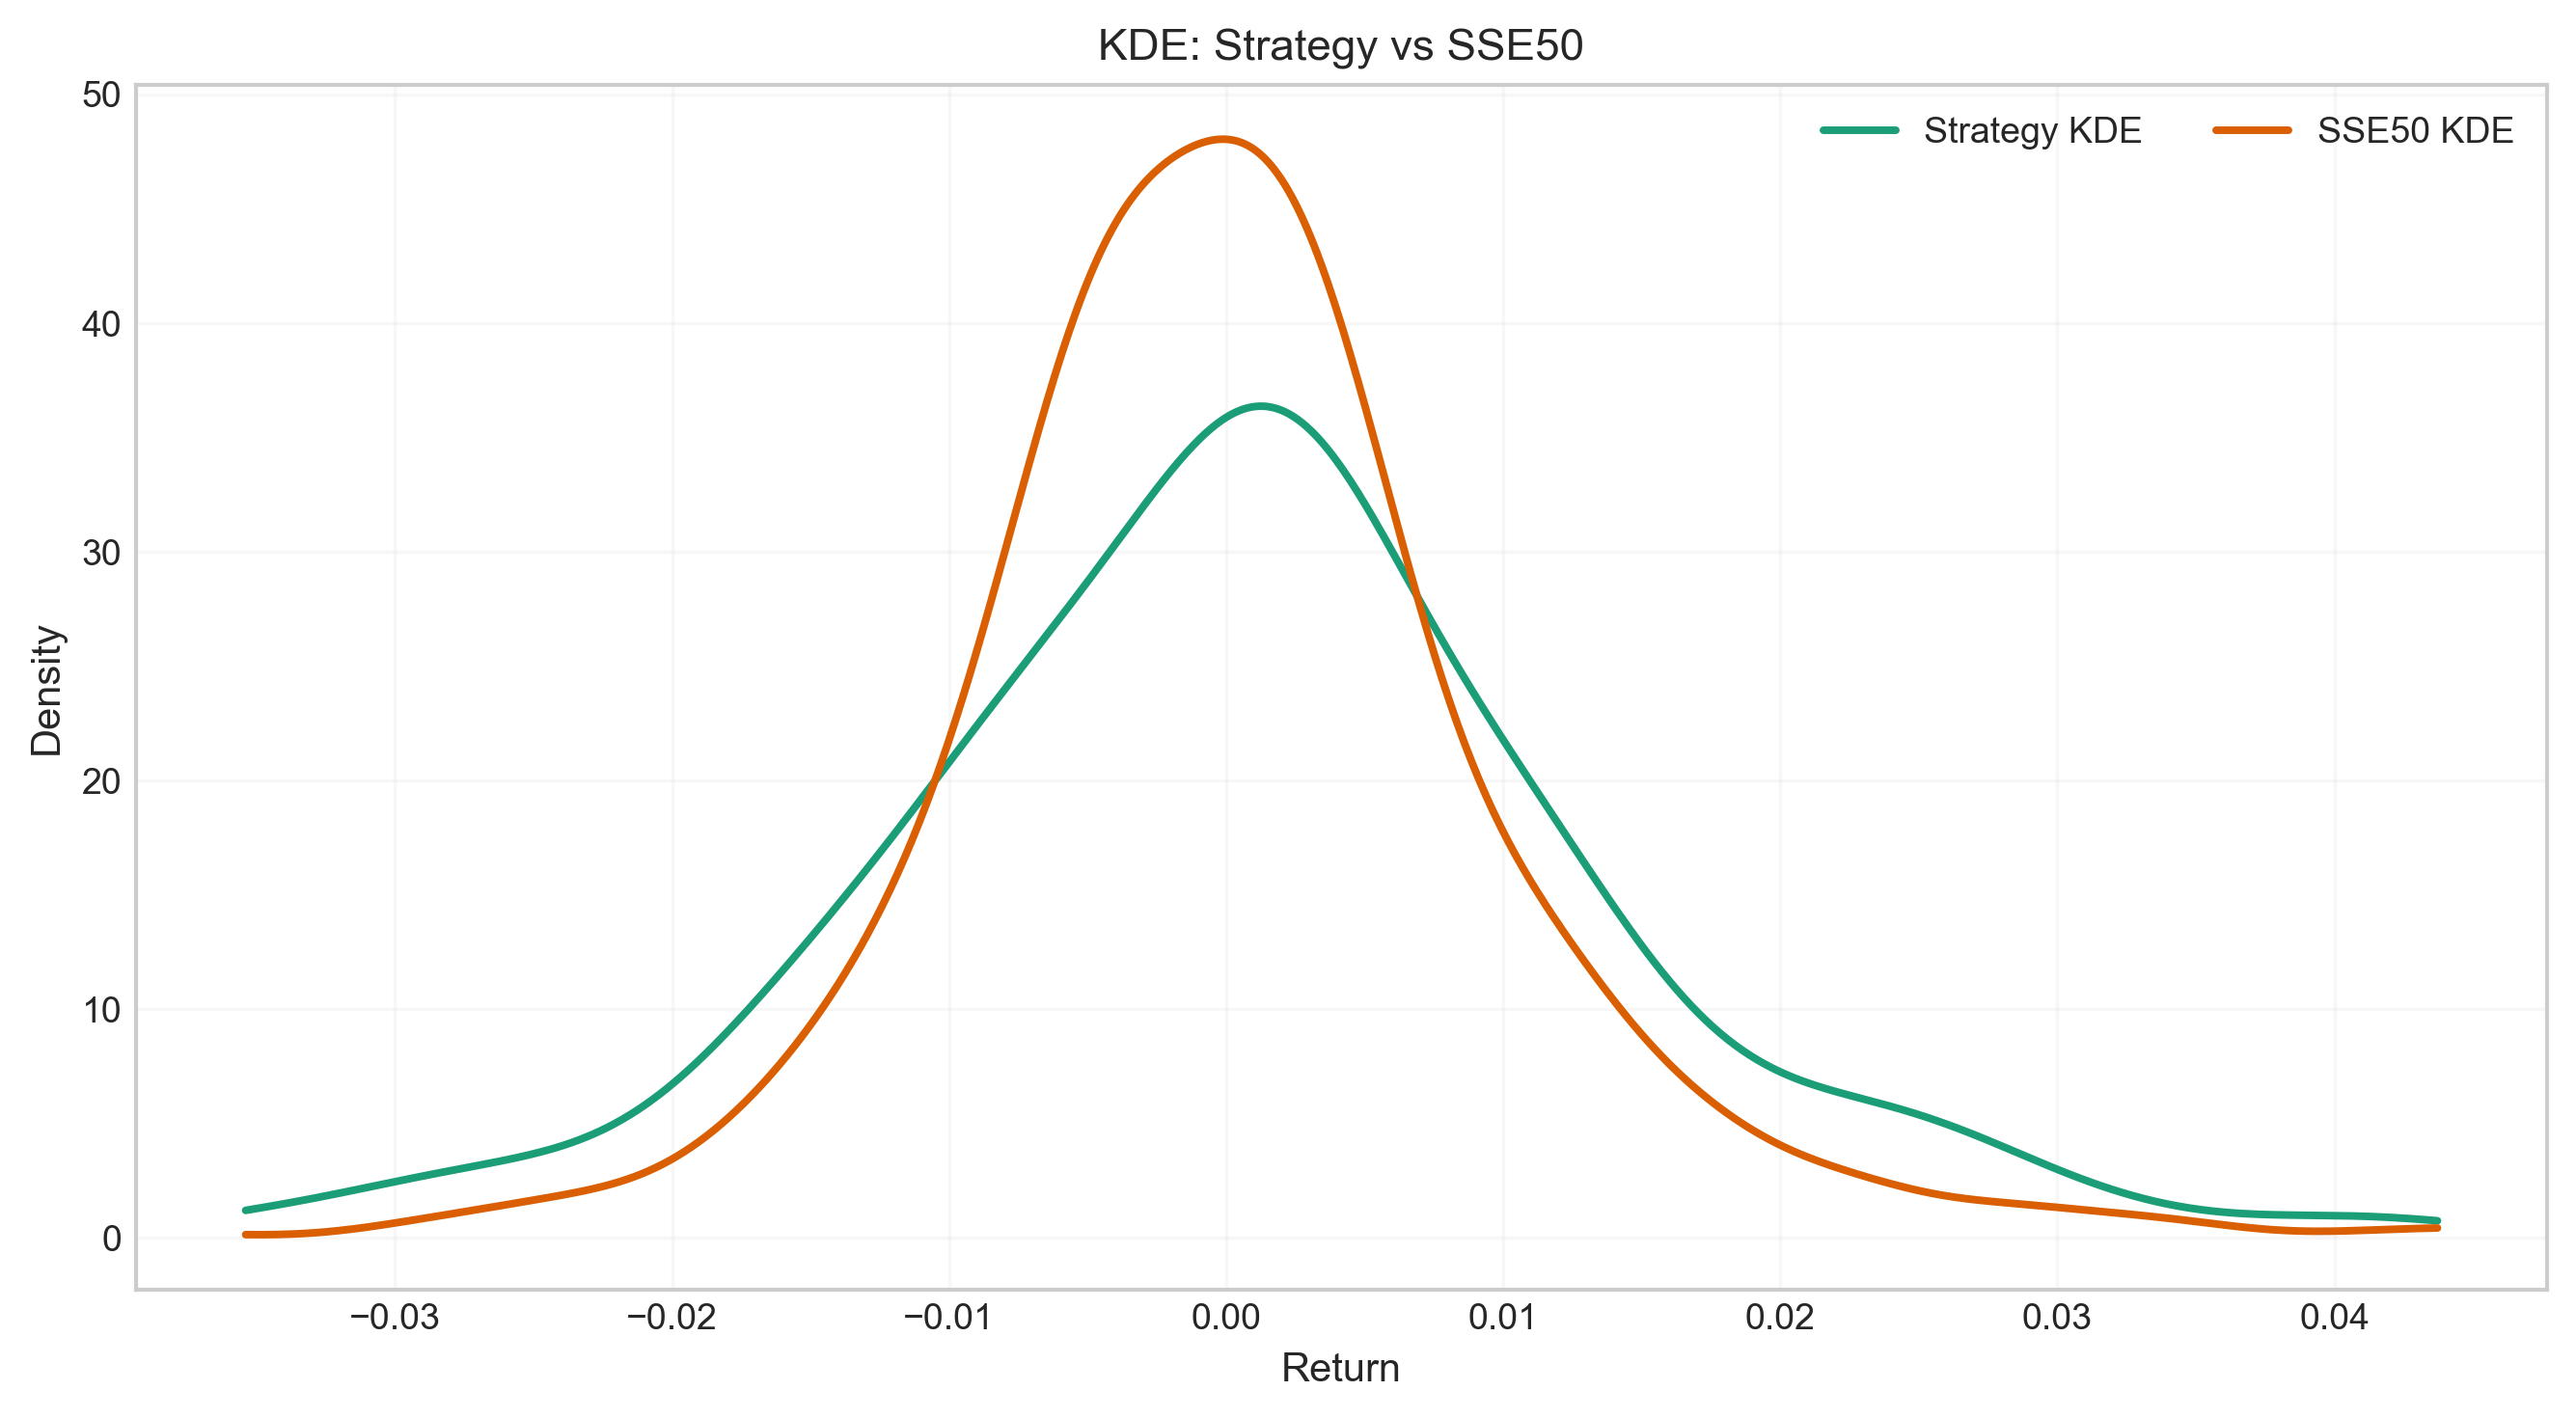

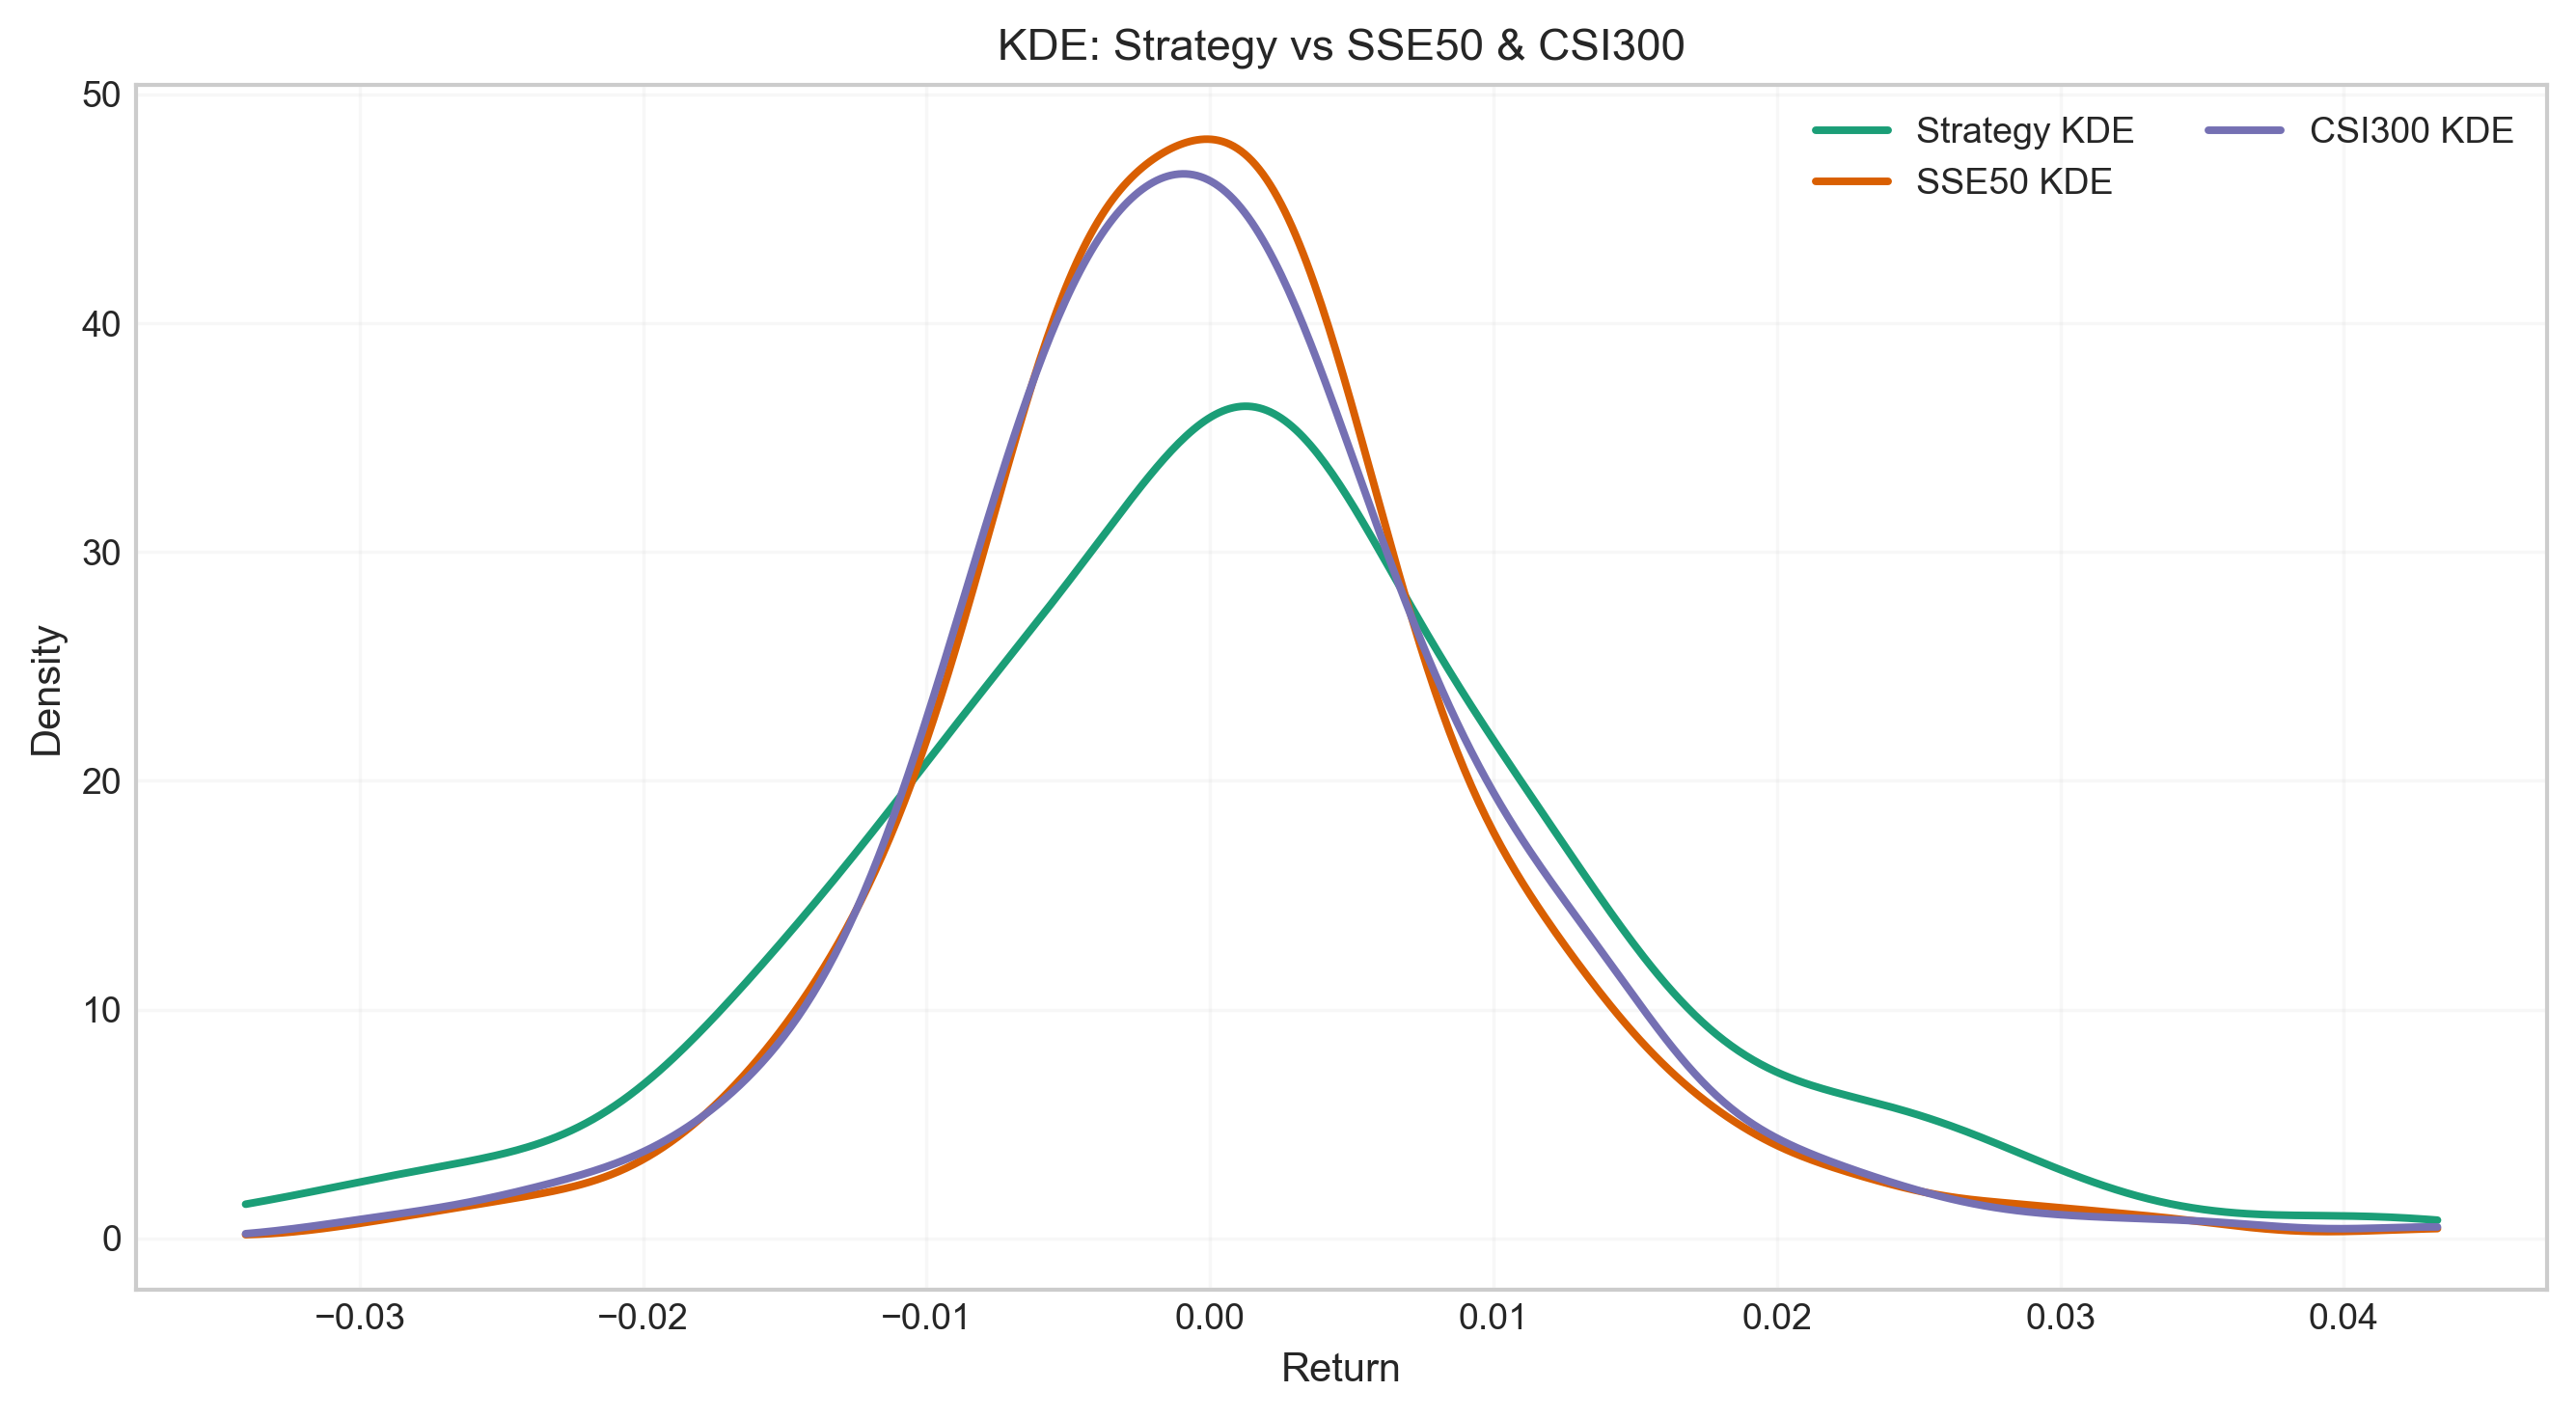


===== Statistical Summary (Daily Returns) =====
              mean  variance       std      skew  kurt_excess    VaR_95  \
Strategy  0.000794  0.000185  0.013616  0.180261     2.154046 -0.019898   
SSE50     0.000104  0.000110  0.010466  0.542694     6.461679 -0.014710   
CSI300    0.000203  0.000120  0.010946  0.480976     9.840722 -0.014855   

            VaR_99  annual_return  annual_vol    sharpe  
Strategy -0.032152       0.200144    0.216146  0.925967  
SSE50    -0.024688       0.026188    0.166143  0.157623  
CSI300   -0.024467       0.051262    0.173756  0.295020  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, gaussian_kde

# ========== USER PARAMETERS ==========
FILE_PATH = "/Users/xiaoquanliu/Desktop/RAF628/Week3/Index_enhanced.csv"
DATE_COL = "Date"
STRATEGY_COL = "strategy_return"
BENCH1_COL = "SSE50_return"
BENCH2_COL = "CSI300_return"

TRADE_DAYS_PER_YEAR = 252
RISK_FREE_ANNUAL = 0.0
USE_GEOMETRIC_ANNUAL = False

SHOW_HIST = False          # 是否在 KDE 下方叠加半透明直方图
HIST_BINS = 70
KDE_POINTS = 600
SHOW_TABLE = True

COLOR_MAP = {
    "Strategy": "#1b9e77",
    "SSE50": "#d95f02",
    "CSI300": "#7570b3"
}

plt.style.use("seaborn-v0_8-whitegrid")

# ========== FUNCTIONS ==========
def infer_frequency(dates: pd.Series):
    if dates.empty:
        return "unknown"
    d = dates.sort_values().diff().dropna()
    med = d.dt.days.median()
    if med <= 1.2:
        return "daily"
    elif med <= 7:
        return "weekly"
    elif med <= 31:
        return "monthly"
    else:
        return "other"

def clean_series(s: pd.Series):
    return s.replace([np.inf, -np.inf], np.nan).dropna()

def compute_metrics(series: pd.Series, ann_factor: int, rf_annual: float = 0.0,
                    geometric: bool = False):
    s = clean_series(series)
    if s.empty:
        return {k: np.nan for k in [
            "mean","variance","std","skew","kurt_excess",
            "VaR_95","VaR_99","annual_return","annual_vol","sharpe"
        ]}
    mean = s.mean()
    var  = s.var(ddof=1)
    std_ = s.std(ddof=1)
    skewness = skew(s, bias=False)
    kurt_ex = kurtosis(s, fisher=True, bias=False)
    var_95 = s.quantile(0.05)
    var_99 = s.quantile(0.01)
    if geometric:
        annual_return = (1 + mean)**ann_factor - 1
    else:
        annual_return = mean * ann_factor
    annual_vol = std_ * np.sqrt(ann_factor)
    sharpe = annual_return / annual_vol if annual_vol > 0 else np.nan
    return {
        "mean": mean,
        "variance": var,
        "std": std_,
        "skew": skewness,
        "kurt_excess": kurt_ex,
        "VaR_95": var_95,
        "VaR_99": var_99,
        "annual_return": annual_return,
        "annual_vol": annual_vol,
        "sharpe": sharpe
    }

def build_metrics_table(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    cols = ["mean","variance","std","skew","kurt_excess",
            "VaR_95","VaR_99","annual_return","annual_vol","sharpe"]
    return df[[c for c in cols if c in df.columns]]

def plot_multi_kde(data_dict, assets, title,
                   show_hist=False, bins=60, kde_points=500,
                   colors=None):
    """
    在同一坐标系上绘制指定 assets 的 KDE（及可选直方图）。
    不绘制正态拟合线。
    """
    if colors is None:
        colors = {}
    # 选出有效数据
    valid = {}
    for a in assets:
        if a in data_dict:
            s = clean_series(data_dict[a])
            if not s.empty:
                valid[a] = s
    if not valid:
        print(f"[WARN] No valid data for {assets}")
        return
    # 统一横轴范围（去除极端尾部）
    concat_all = pd.concat(valid.values())
    x_min, x_max = np.percentile(concat_all, [0.5, 99.5])
    xs = np.linspace(x_min, x_max, kde_points)

    fig, ax = plt.subplots(figsize=(9, 5))
    for name, series in valid.items():
        col = colors.get(name, None)
        if show_hist:
            ax.hist(series, bins=bins, density=True, alpha=0.18,
                    color=col, label=f"{name} Hist")
        try:
            kde = gaussian_kde(series)
            ax.plot(xs, kde(xs), color=col, linewidth=1.9,
                    label=f"{name} KDE")
        except Exception as e:
            print(f"[KDE Fail] {name}: {e}")

    ax.set_title(title)
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.legend(ncol=2, frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

def main():
    # 1. Load
    df = pd.read_csv(FILE_PATH)
    df.columns = [c.strip() for c in df.columns]
    if DATE_COL not in df.columns:
        raise ValueError(f"Date column '{DATE_COL}' not found.")
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
    df = df.sort_values(DATE_COL)

    for col in [STRATEGY_COL, BENCH1_COL, BENCH2_COL]:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    freq_guess = infer_frequency(df[DATE_COL])
    print(f"[INFO] Inferred frequency: {freq_guess}")

    # 2. Metrics
    metrics = {
        "Strategy": compute_metrics(df[STRATEGY_COL], TRADE_DAYS_PER_YEAR,
                                    RISK_FREE_ANNUAL, geometric=USE_GEOMETRIC_ANNUAL),
        "SSE50": compute_metrics(df[BENCH1_COL], TRADE_DAYS_PER_YEAR,
                                 RISK_FREE_ANNUAL, geometric=USE_GEOMETRIC_ANNUAL),
        "CSI300": compute_metrics(df[BENCH2_COL], TRADE_DAYS_PER_YEAR,
                                  RISK_FREE_ANNUAL, geometric=USE_GEOMETRIC_ANNUAL)
    }
    table = build_metrics_table(metrics)

    # 3. Data dict for plotting
    data_dict = {
        "Strategy": df[STRATEGY_COL],
        "SSE50": df[BENCH1_COL],
        "CSI300": df[BENCH2_COL]
    }

    # 图1：Strategy + SSE50
    plot_multi_kde(data_dict,
                   assets=["Strategy", "SSE50"],
                   title="KDE: Strategy vs SSE50",
                   show_hist=SHOW_HIST,
                   bins=HIST_BINS,
                   kde_points=KDE_POINTS,
                   colors=COLOR_MAP)

    # 图2：Strategy + SSE50 + CSI300
    plot_multi_kde(data_dict,
                   assets=["Strategy", "SSE50", "CSI300"],
                   title="KDE: Strategy vs SSE50 & CSI300",
                   show_hist=SHOW_HIST,
                   bins=HIST_BINS,
                   kde_points=KDE_POINTS,
                   colors=COLOR_MAP)

    # 4. Table
    if SHOW_TABLE:
        print("\n===== Statistical Summary (Daily Returns) =====")
        print(table.round(6))

if __name__ == "__main__":
    main()
